# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from operator import itemgetter  
from collections import OrderedDict

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize, StandardScaler, Normalizer, MinMaxScaler, minmax_scale, robust_scale
from sklearn.decomposition import PCA

In [100]:
data = pd.read_csv('Data/training_1.csv')
data2 = pd.read_csv('Data/training_2.csv')
data3 = pd.read_csv('Data/test.csv')

data2.columns = data2.columns.str.replace(' ', '')

data['DATETIME'] = pd.to_datetime(data['DATETIME'], format='%d/%m/%y %H')
data2['DATETIME'] = pd.to_datetime(data2['DATETIME'], format='%d/%m/%y %H')
data3['DATETIME'] = pd.to_datetime(data3['DATETIME'], format='%d/%m/%y %H')




train_data = data.drop(columns=['ATT_FLAG', 'DATETIME'])
test_data1 = data2.drop(columns=['ATT_FLAG', 'DATETIME'])
test_data2 = data3.drop(columns=['DATETIME'])
features = train_data.columns


for col in train_data.columns:
    train_data[col] = train_data[col].astype('float')
    test_data1[col] = test_data1[col].astype('float')
    test_data2[col] = test_data2[col].astype('float')

# Familiarization task – 1 A4 

Answer the following questions:
* What kinds of signals are there?
* Are the signals correlated? Do they show cyclic behavior?
* Is predicting the next value in a series easy or hard? Use any method from class.

Visualize these types, the presence or absence of correlation, and the performance of prediction.

TODOS:
* Little bit more about cyclic behaviour
* Draw conclusions from predictions

### What kinds of signals are there?

The data is categorized as follows:
* T Are the water tanks
    * L_Tx stands for the water level in the tanks (float)
* PU Are the pumps
    * F_PUx(x) stands for the flow through the pumt(float)
    * S_PUx(x) stands for the status of the pump (on (1) / off (0)) (binary)
* V is a valve
    * F_Vx stands for flow through the valve (float) 
    * S_Vx stands for the status of the valve (open (1) / closed (0)) (binary)
* J are junctions
    * P_Jxxx stands for the pressure in the junction (float)

* ATT_FLAG is the attack flag (normal (0) / attack (1) / unknown (-999))

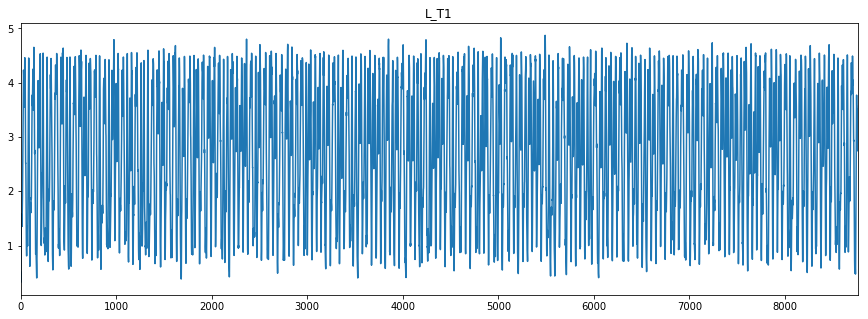

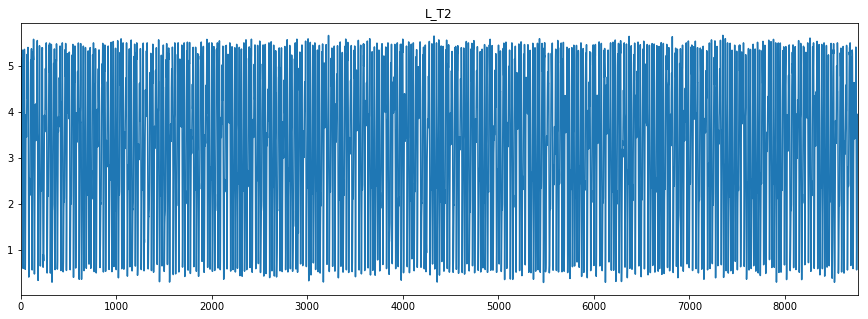

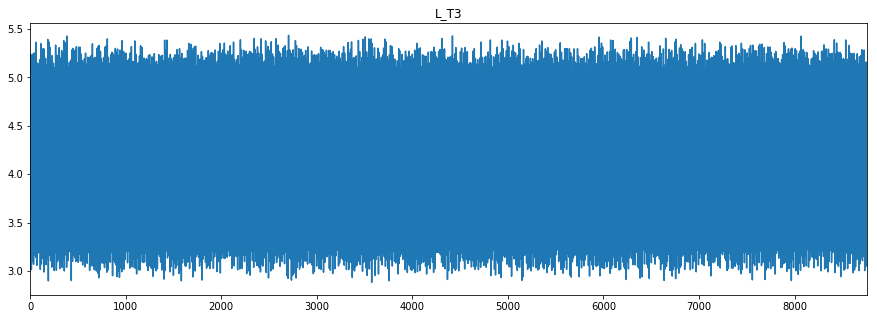

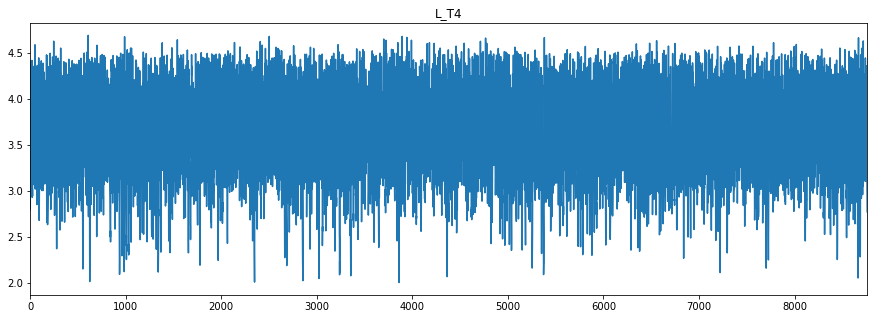

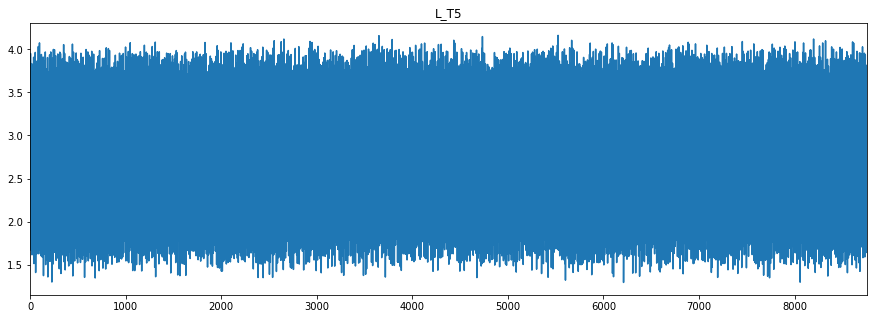

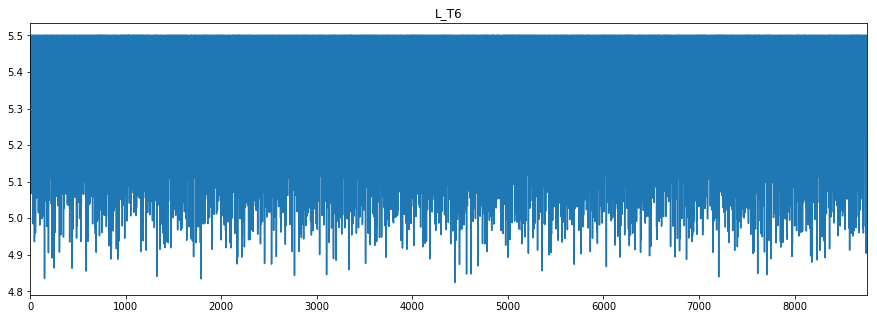

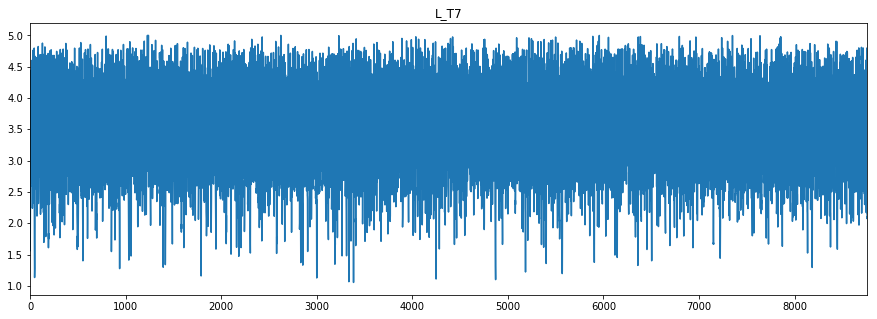

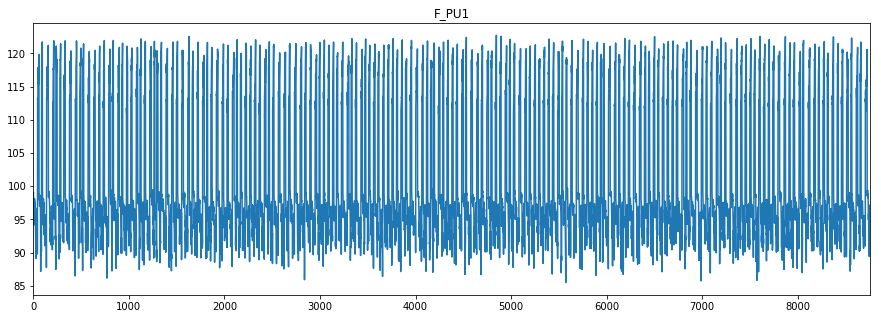

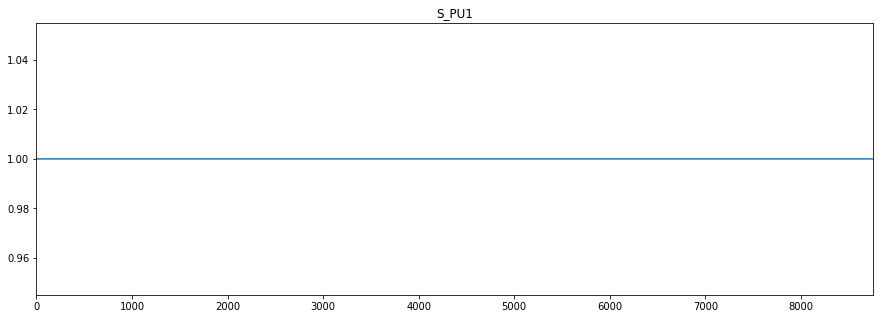

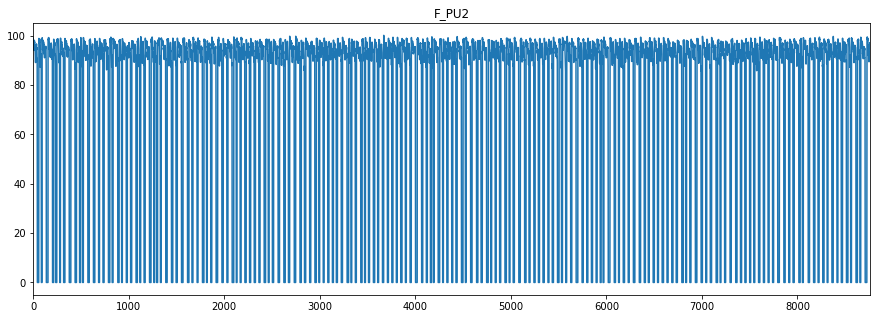

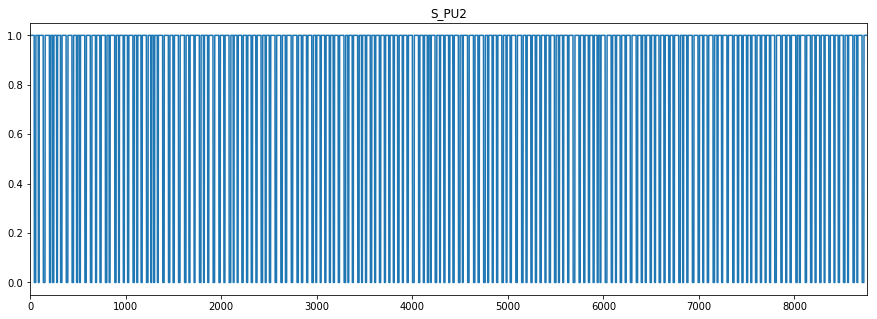

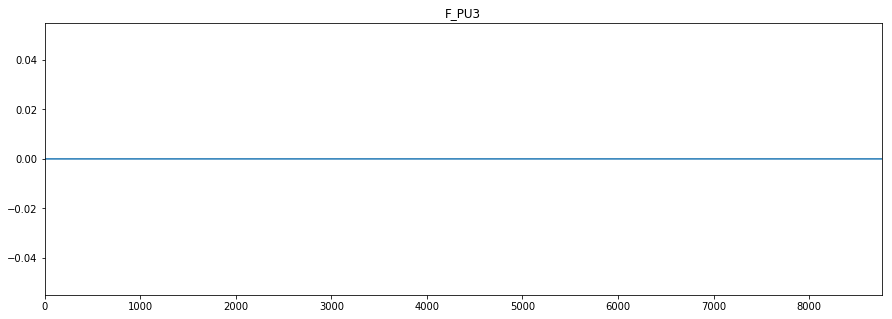

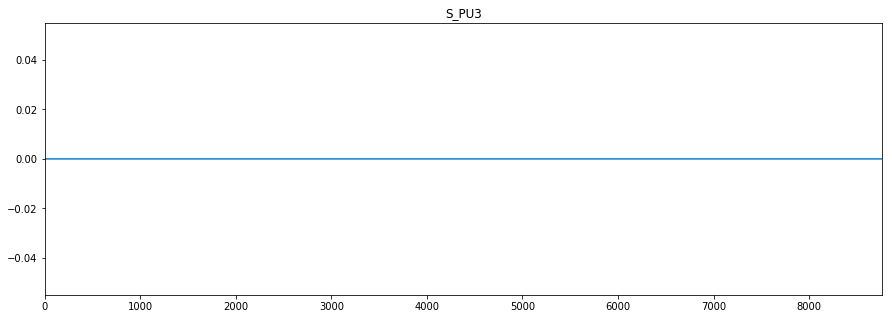

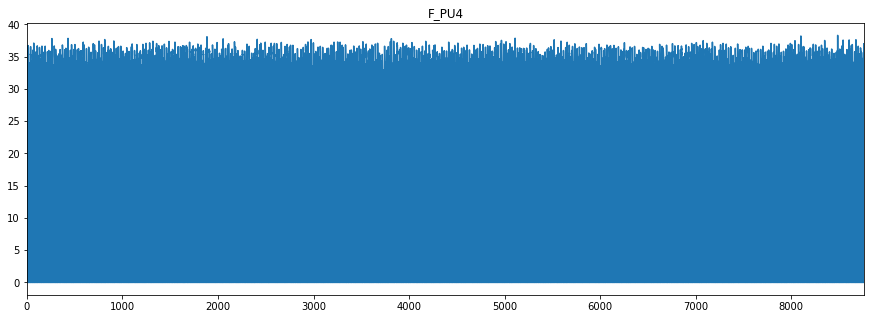

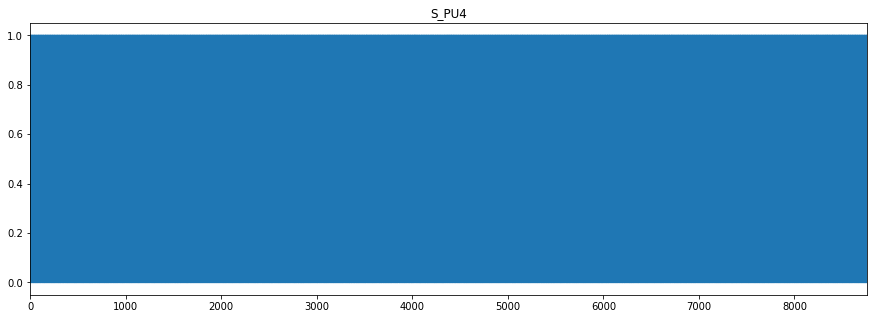

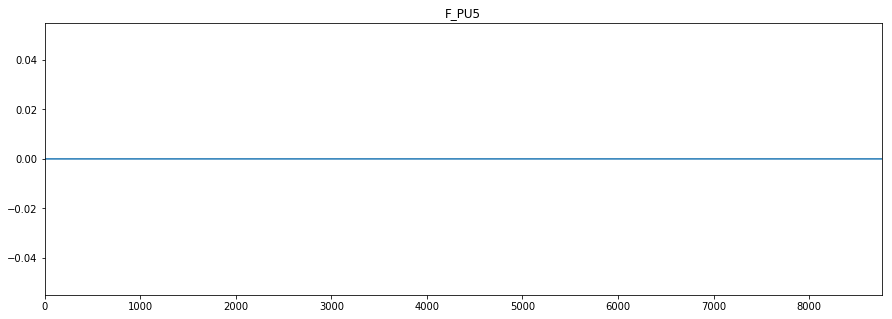

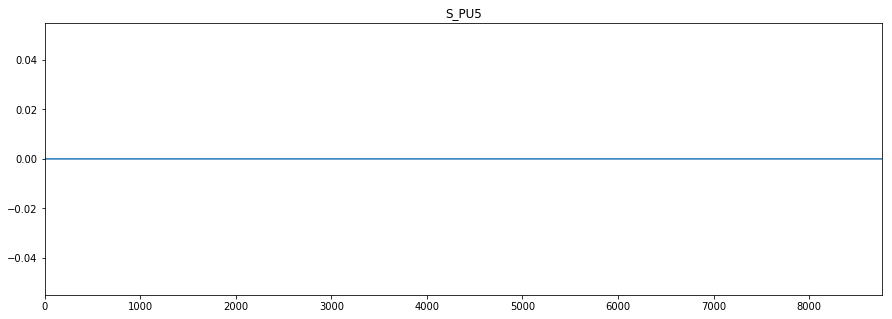

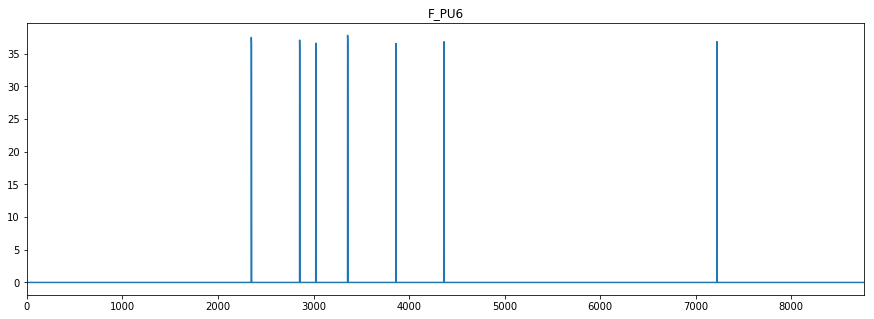

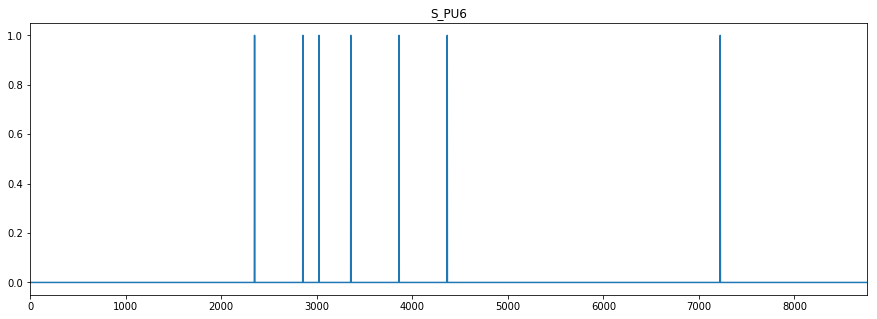

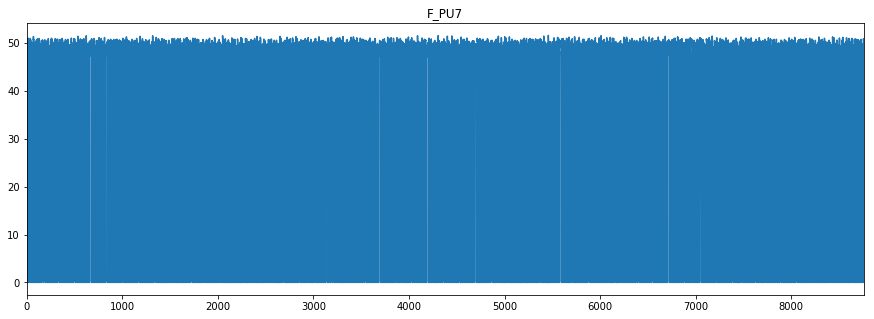

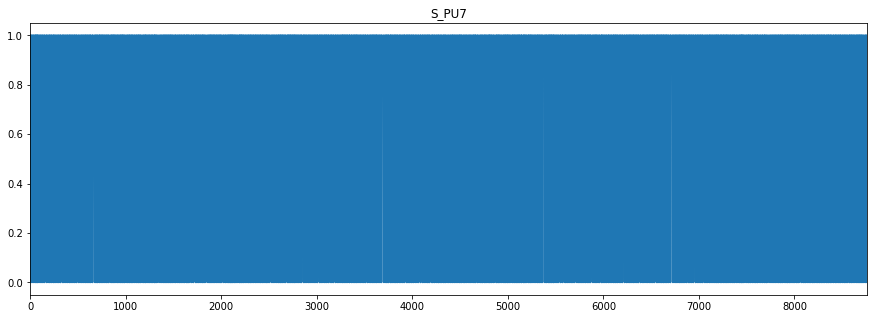

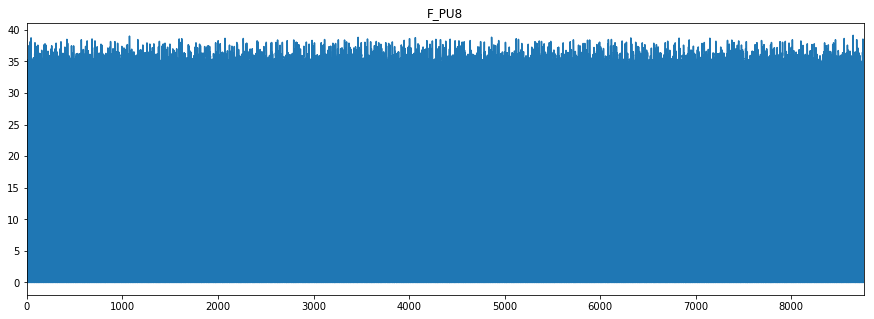

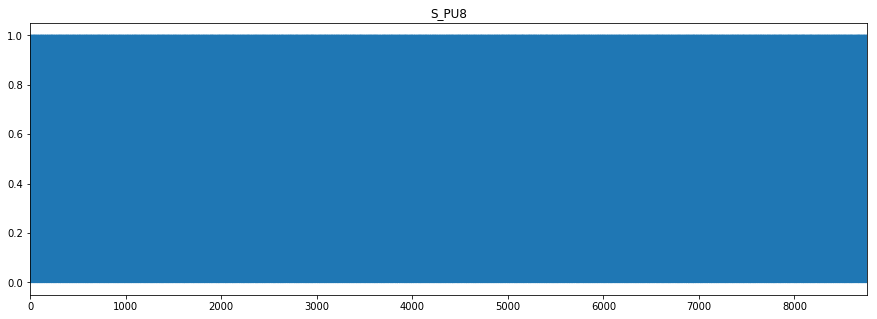

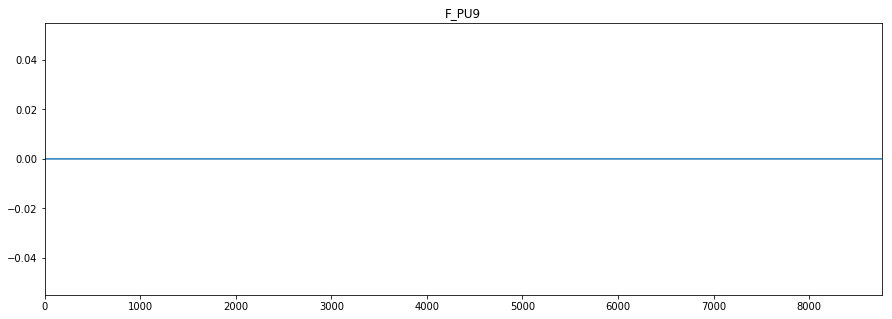

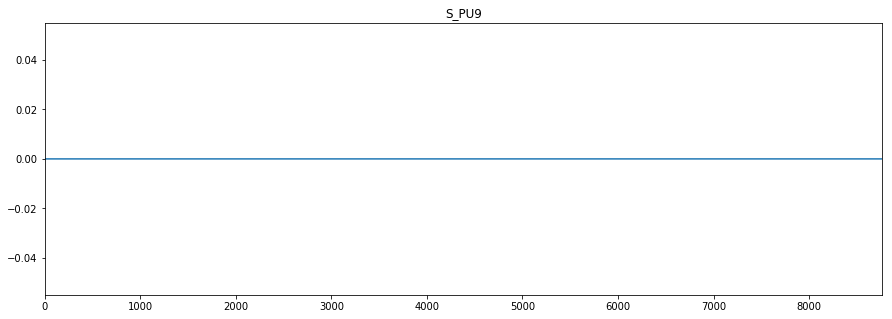

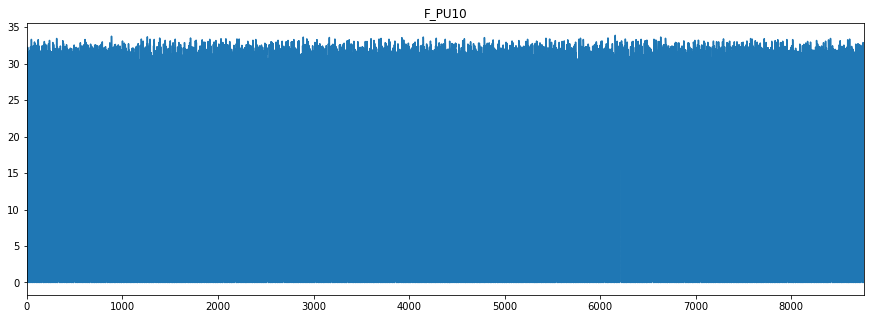

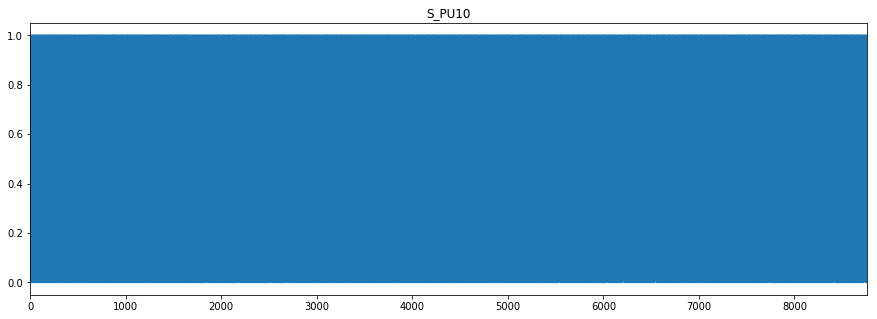

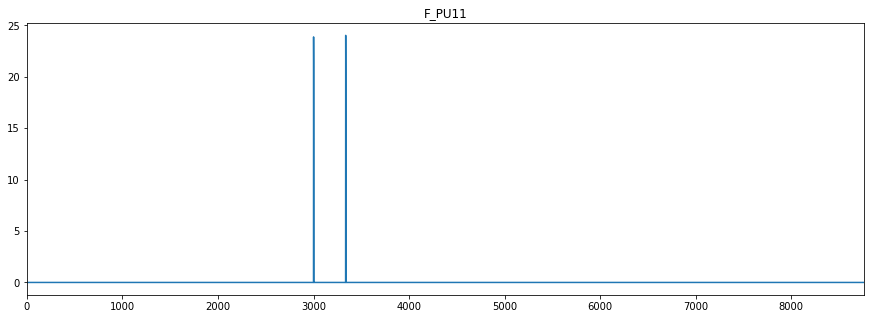

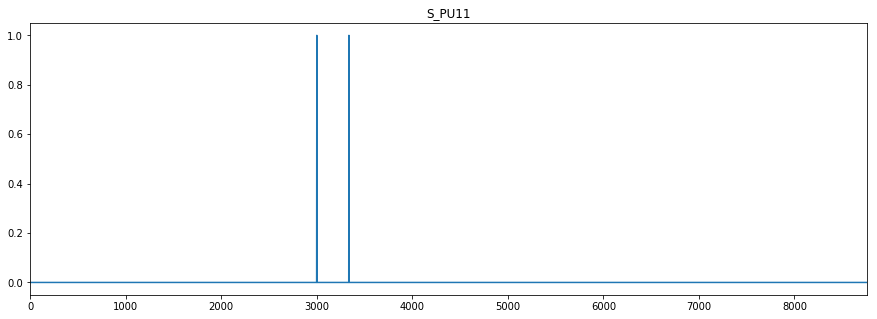

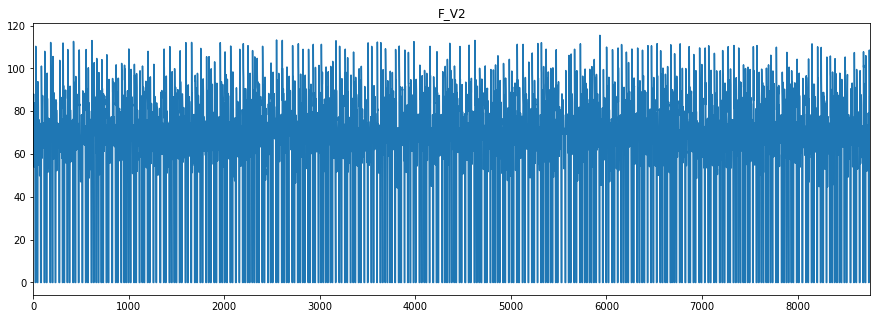

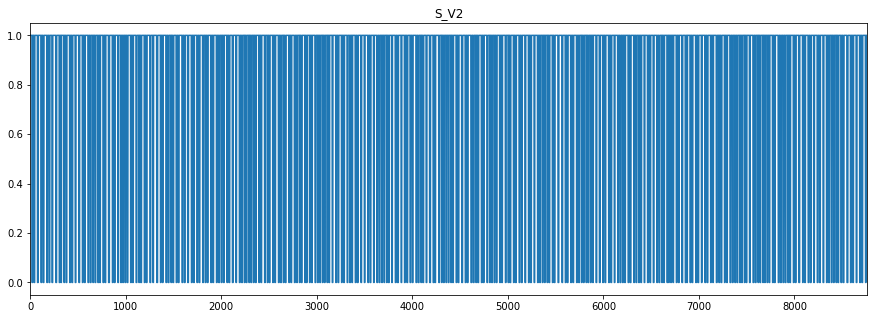

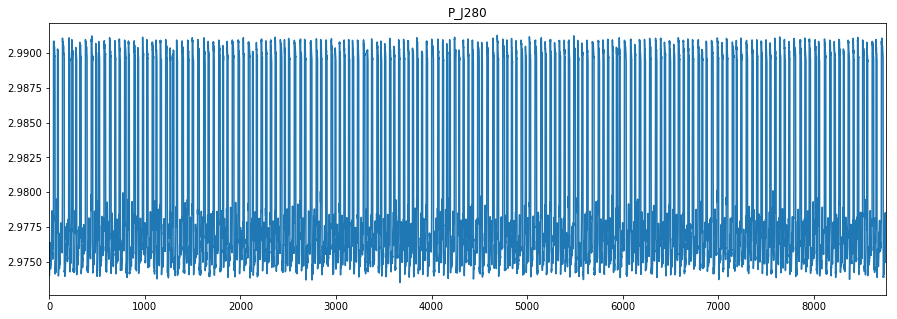

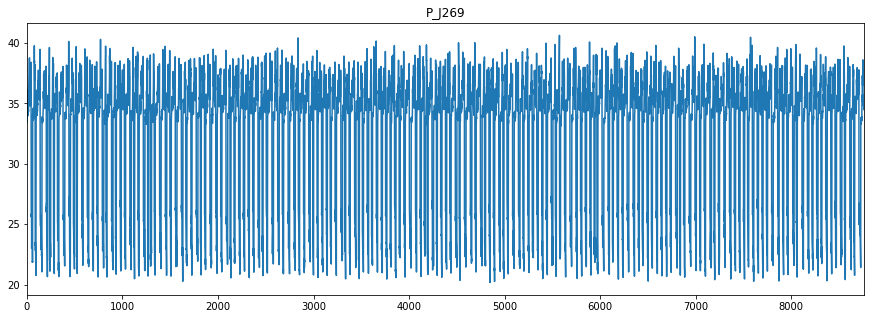

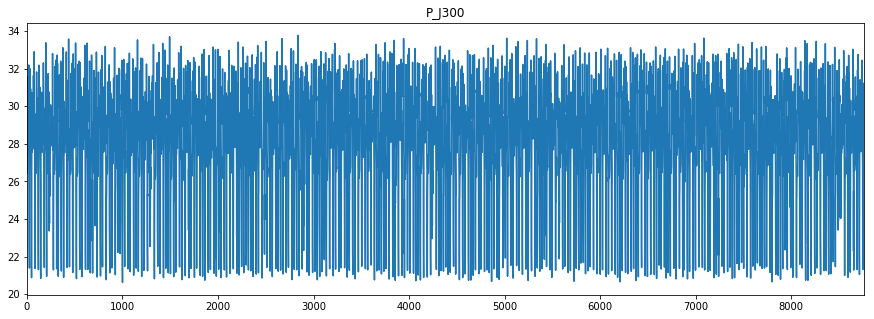

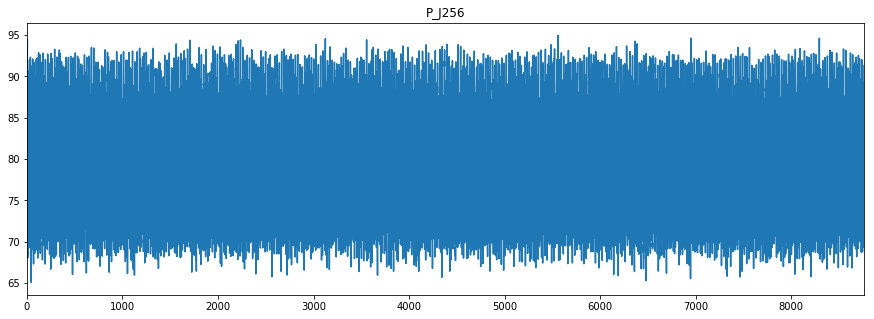

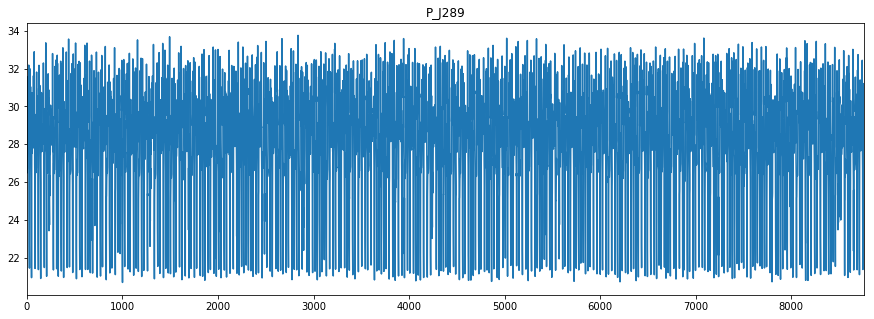

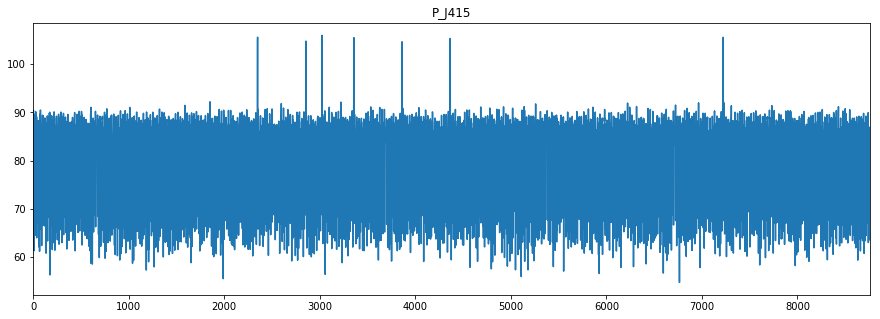

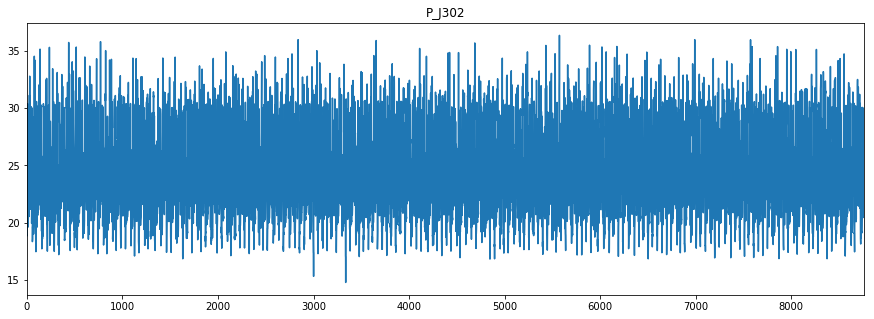

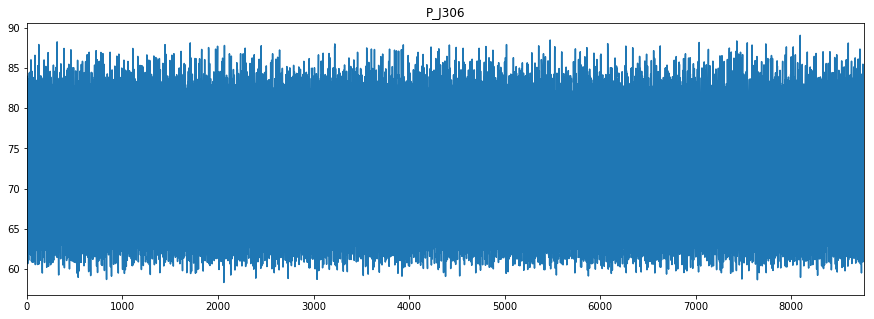

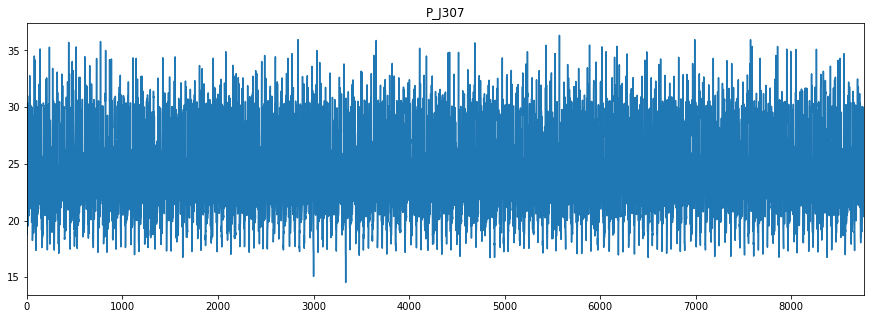

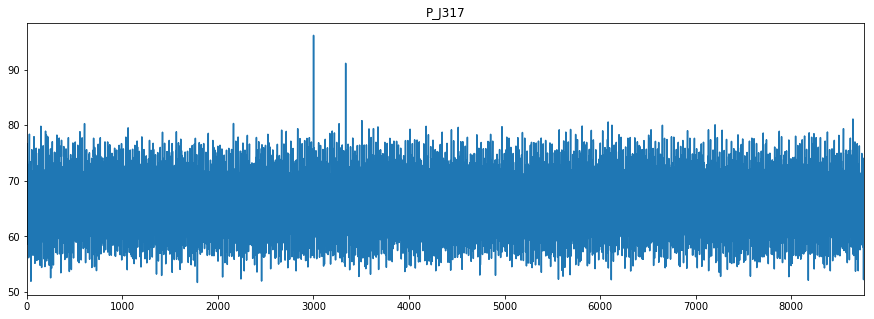

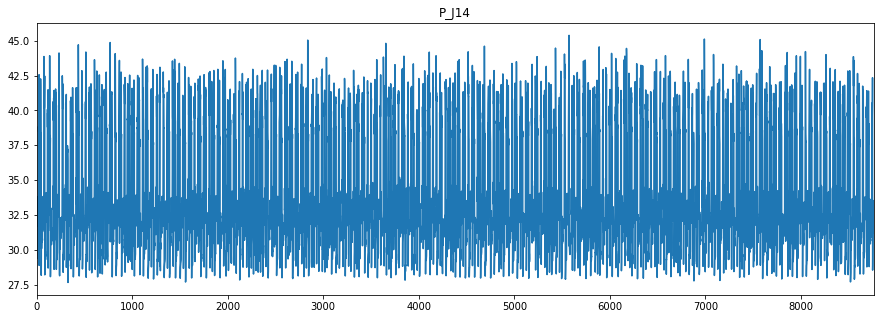

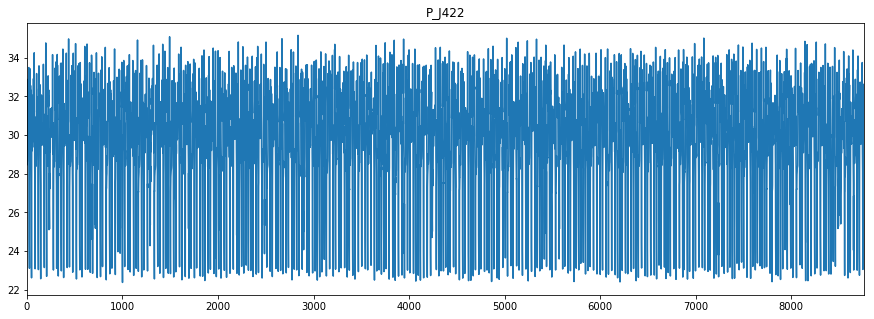

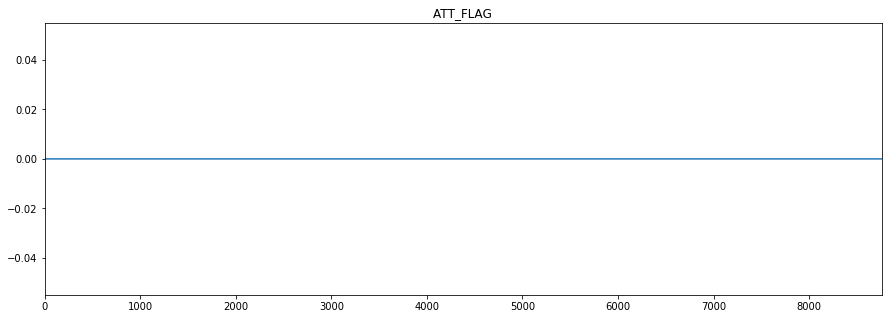

<Figure size 432x288 with 0 Axes>

In [126]:
for i, cl in enumerate(data.columns[1:]):
    plt.title(cl)
    data[cl].plot(figsize=(15,5))
    plt.show()
    plt.clf()

### Are the signals correlated? Do they show cyclic behavior?

As one can see in the correlation heatmap below there is some data correlated

The interesting ones for now are the correlations between actuators and sensors (not from the same machine). Taking the lowest and highest correlations <-1:-0.75> and <0.75:1> from the subset described gives some interesting plots. Although not all the time deltas are equal there is a clear cycle visible between waterlevels/flows/pressure and when actuators are activated

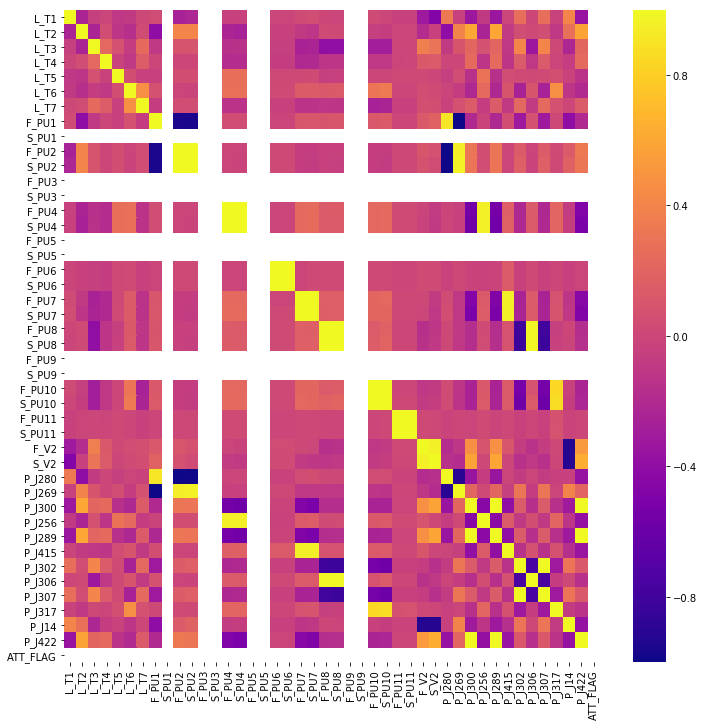

In [3]:
f, ax = plt.subplots(figsize=(12, 12))
corr = data.corr()
sns.heatmap(data.corr(), cmap='plasma')
plt.show()

In [5]:
cr_series = corr.unstack().sort_values(ascending=False).drop_duplicates().dropna()
cr = pd.DataFrame(cr_series)
cr['high'] = cr_series.between(-0.75, 0.75, inclusive=True)
cr = cr[cr['high']==False].drop('high', axis='columns').reset_index().set_axis(['x', 'y', 'correlation'], axis='columns', inplace=False)

# Filter correlations with itself
cr = cr[cr['x'] != cr['y']]

# Filter correlations between status and flow of same machine
cr = cr[cr['x'].str.split('_', expand=True)[1] != cr['y'].str.split('_', expand=True)[1]]

# Most interesting are the correlatiosn between sensors and actuators
cr = cr[(cr['x'].str.split('_', expand=True)[0] =='S') | (cr['y'].str.split('_', expand=True)[0]=='S')]

display(HTML(cr.to_html()))


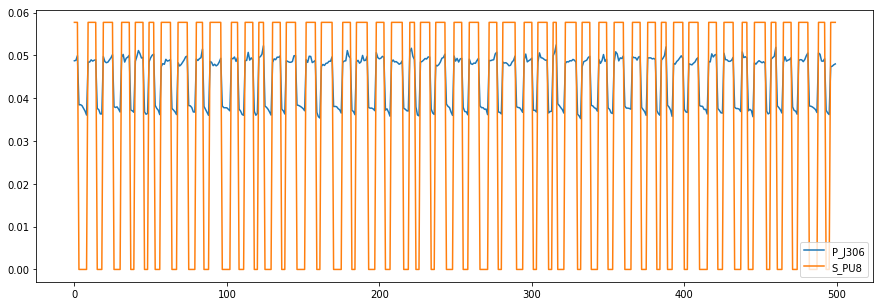

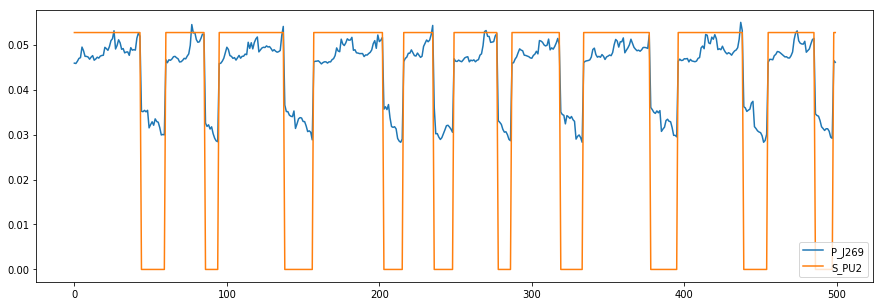

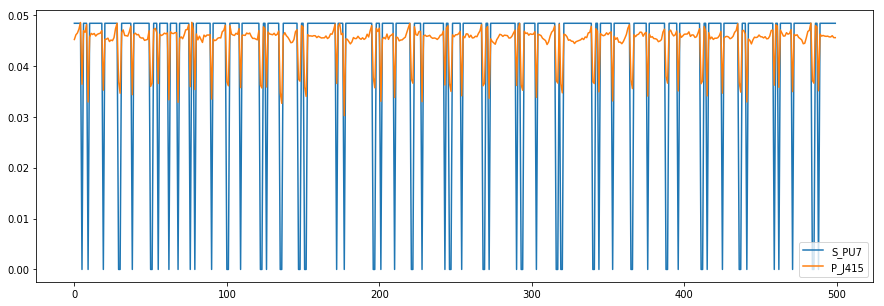

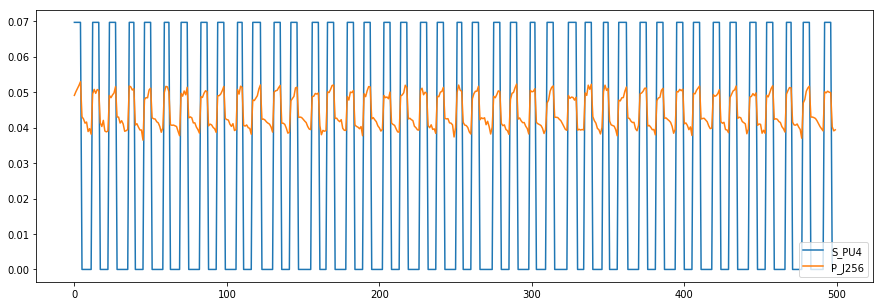

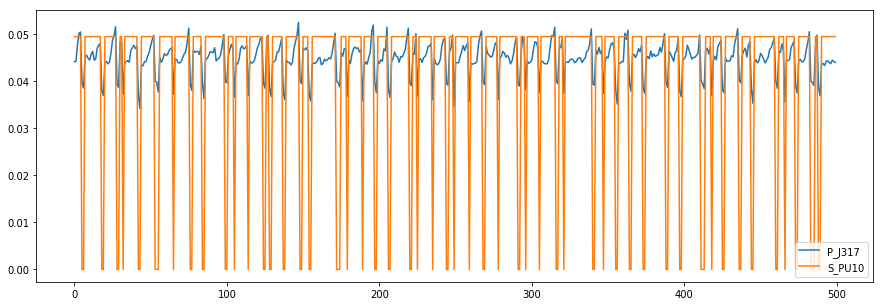

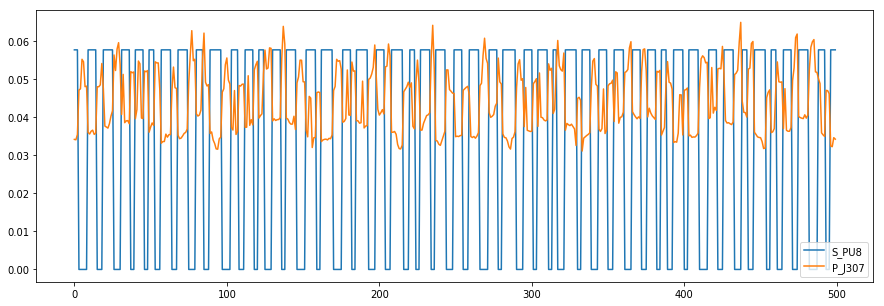

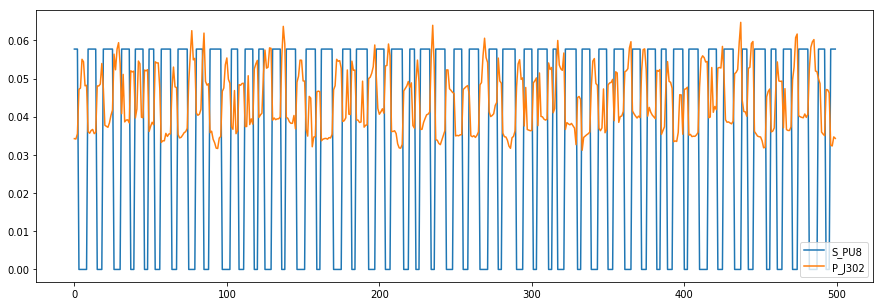

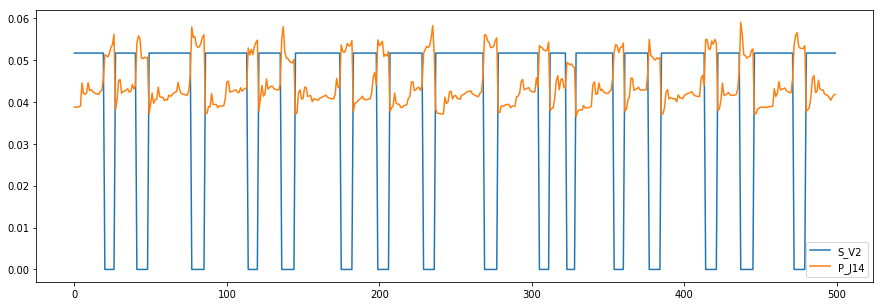

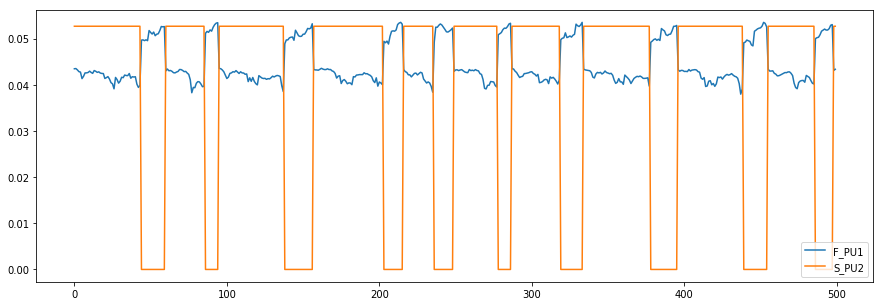

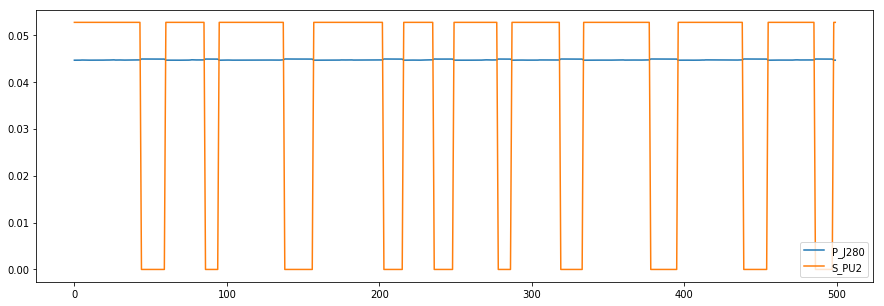

In [6]:
for row in cr.itertuples():
    plt.figure(figsize=(15,5))
    plt.plot(normalize(data[row[1]][:500].values.reshape(1, -1)).reshape(-1, 1), label=row[1])
    plt.plot(normalize(data[row[2]][:500].values.reshape(1, -1)).reshape(-1, 1), label=row[2])
    plt.legend(loc = 'lower right')
    plt.show()
#     plt.clf()

### Is predicting the next value in a series easy or hard? Use any method from class.

Using Auto regressive (AR)

// https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/

Test MSE: 0.036


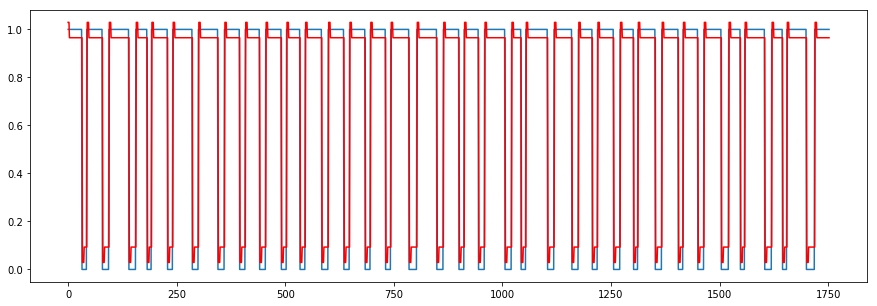

In [7]:
def predict(coef, history):
    #initialize on constant
    yhat = coef[0]
    # sum( phi(i) * X(t-1)) for i=1 till i=p
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

signal = 'S_PU2'
train_size = int(len(data)*0.8)
train_data = data[signal][0:train_size]
test_data = data[signal][train_size:].reset_index(drop='true')
predictions = list()

# Order for AR
p=5
#Create and train model
model = AR(train_data)
model_fit = model.fit(p)
# Get coefficients (+ constant)
coef = model_fit.params
# Retreive last p points
history = train_data[-p:].to_list()

# Predict same amount as values as availale in test set
for t in range(len(test_data)):
    # predict next value and add to list
    yhat = predict(coef, history)
    predictions.append(yhat)
    
    # add original point to history for next prediction
    obs = test_data[t]
    history.append(obs)
    
error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.figure(figsize=(15,5))
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()

# ARMA task 

Learn an autoregressive moving average model for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model. 

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?

TODOS:
* Look at picking sensor data (now based on attack sheet)
* use autocorrelation to indetify order
* determine useing AIC
* Decide on threshold for attack
* write about this assignment
    

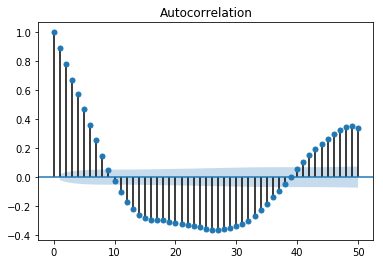

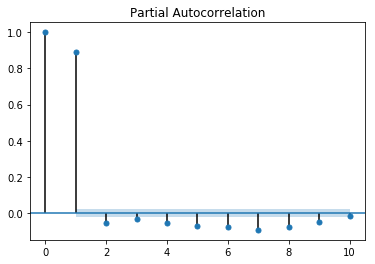

In [3]:
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

signal = 'F_PU1'

plot_acf(data[signal], lags=50)
plt.show()

plot_pacf(data[signal], lags=10)
plt.show()

In [80]:
def AIC(data):
    best_p=1
    best_q=0
    best_score = float("inf")

    for i in range(1,9):
        for j in range(0,6):
            try:
                model = ARMA(data, (i,j))
                model_fit = model.fit(disp=0)
                score = model_fit.aic
                if score < best_score:
                    best_score = score
                    best_p = i
                    best_q = j
            except Exception as e:
                    break
    return best_score, best_p, best_q

In [101]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
try:
    arma_param = pd.read_csv('Data/arma_param.csv')
    print('Loaded:')
    print(arma_param)
except:
    arma_param = pd.DataFrame(columns=['feature','p','q', 'score'])
    for col in features:
        score, p, q = AIC(train_data[col][:2000])
        arma_param = arma_param.append({'feature':col,'p':p,'q':q,'score':score}, ignore_index=True)
        print(col,': (',p,',',q,')')
    arma_param = arma_param.reset_index(drop=True).set_index('feature')
    arma_param.to_csv('Data/arma_param.csv')
    print(arma_param)
    

Loaded:
   feature  p  q         score
0     L_T1  8  5 -3.058122e+03
1     L_T2  7  4 -3.573662e+02
2     L_T3  8  4 -2.059657e+03
3     L_T4  5  2  1.828297e+03
4     L_T5  4  4 -2.133071e+02
5     L_T6  1  4 -2.986272e+03
6     L_T7  4  5  3.138211e+03
7    F_PU1  4  3  1.166425e+04
8    S_PU1  1  0           inf
9    F_PU2  5  3  1.719266e+04
10   S_PU2  5  4 -1.011738e+03
11   F_PU3  1  0           inf
12   S_PU3  1  0           inf
13   F_PU4  8  2  1.457518e+04
14   S_PU4  7  5  3.042906e+02
15   F_PU5  1  0           inf
16   S_PU5  1  0           inf
17   F_PU6  1  0           inf
18   S_PU6  1  0           inf
19   F_PU7  8  3  1.680106e+04
20   S_PU7  8  5  1.312875e+03
21   F_PU8  8  3  1.520033e+04
22   S_PU8  8  3  9.463836e+02
23   F_PU9  1  0           inf
24   S_PU9  1  0           inf
25  F_PU10  5  5  1.502197e+04
26  S_PU10  7  3  1.318424e+03
27  F_PU11  1  0           inf
28  S_PU11  1  0           inf
29    F_V2  8  5  1.770101e+04
30    S_V2  8  5 -2.266914e+02


In [105]:
#  http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARMA

def predict_point(coef, vector):
    # AR: sum( phi(i) * X(t-1)) for i=1 till i=p
    # MA: sum( phi(i) * eps(t-1)) for i=1 till i=q (eps is residual error noise)
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * vector[-i]
    return yhat

# p = order of AR     q = order of MA
def arma_predict(train, test, flags, feature_name, p=2, q=2):
    avg = np.mean(train)
    train = train - avg
    test = test- avg
    
    
    model = ARMA(train, (p,q))
    model_fit = model.fit(disp=0)

    # Copy training set parameters for testing    
    ar_coef = model_fit.arparams
    ma_coef = model_fit.maparams    
    residuals = model_fit.resid.tolist()
    history = train.tolist()    
    predictions=[]
    
    # Predict same amount as values as availale in test set
    for i in range(len(test)):
        # predict next value and add to list
        yhat = predict_point(ar_coef, history) + predict_point(ma_coef, residuals)
        predictions.append(yhat)

        # add original point to history for next prediction
        obs = test[i]
        history.append(obs)
        # calculate the risudual as input for the moving average
        residuals.append(obs-yhat)
    
    # Calculate the residuals of the predictions without history
    res = np.subtract(test,predictions)
    # absolute values of residual
    res_abs = np.abs(res)
    # sort residuals
    res_sorted = np.sort(res_abs)
    
    # Calculate the avarage of the highest 5% of the residuals     
    threshold = np.mean(res_sorted[int(0.95*len(res_sorted)):])
    # Set the detection threshold as 1.5 times the mean of highest residuals since anomalies are less frequent than normal data
    threshold *= 1.5
    
    # check the predictions for anomalies 
    attacks = []
    for i in range(len(test)):
        if (res_abs[i] > threshold): #or predictions[i] < res_min) and i > 500:
            attacks.append(1)
        else:
            attacks.append(0)
            
    # group attacks if they are close together
    group_threshold = 25
    for i, row in enumerate(attacks):
        if row == 1:
            if i+group_threshold >= len(attacks):
                group_threshold = len(attacks) - i - 1
            for check in range(i+group_threshold,i, -1):
                if attacks[check] == 1:
                    for fill in range(check, i, -1):
                        attacks[fill] = 1
        
        
    plt.figure(figsize=(15,5))
    plt.hlines(threshold, 0, len(attacks), color='black', label='threshold')
    plt.plot(list(res_abs), color='cyan', label='residual error')
    plt.plot(list(test), color='blue', label='test')
    plt.plot(list(predictions), color='green', label='pred')
    plt.plot(flags, color='red', label='flags')
    plt.plot(attacks, color='purple', label='detected')
    axes=plt.gca()
    axes.set_ylim((-50, 50))
    plt.legend()
    plt.title('ARMA prediction attack on: '+ feature_name)
    plt.show()

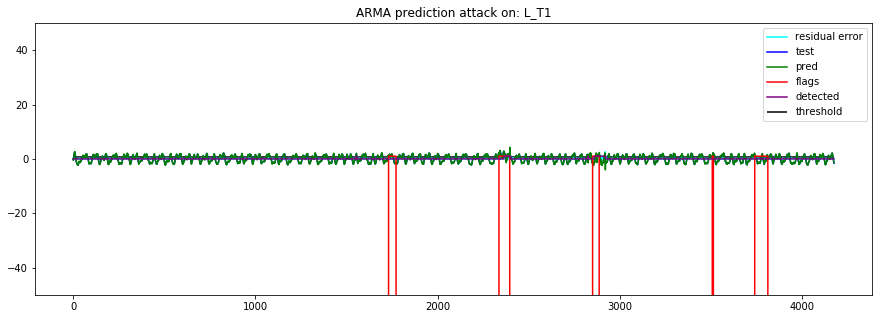

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


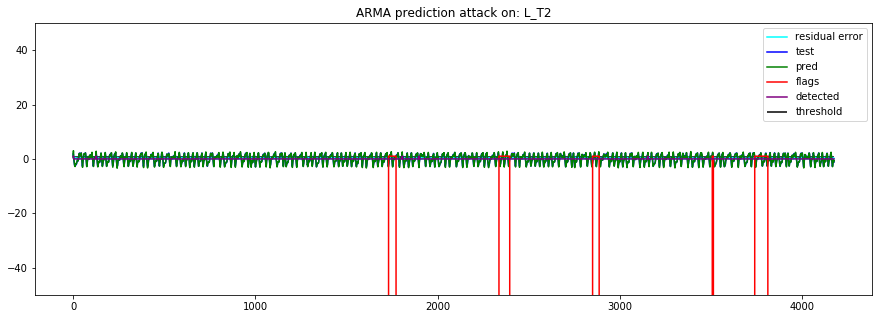

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


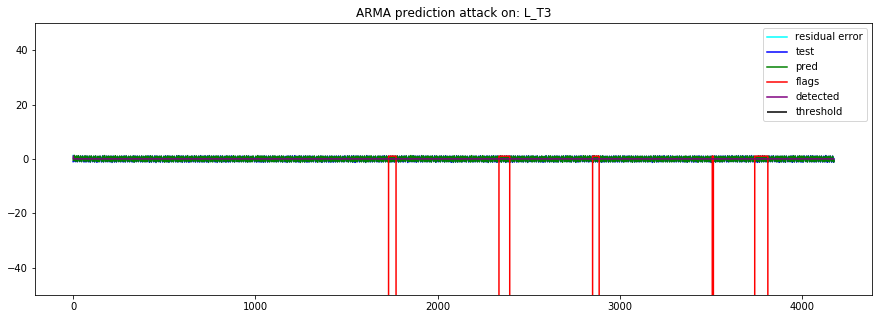

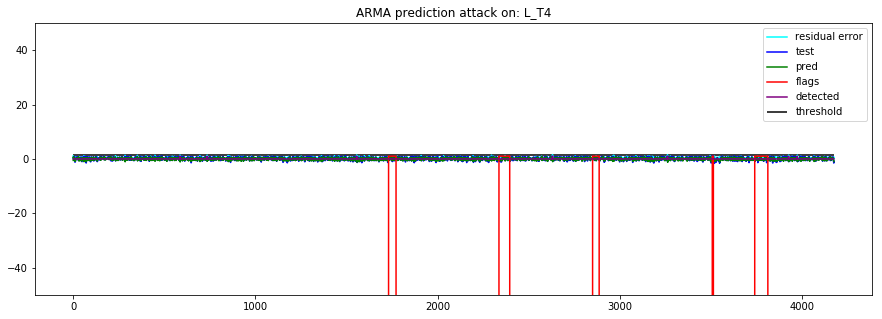

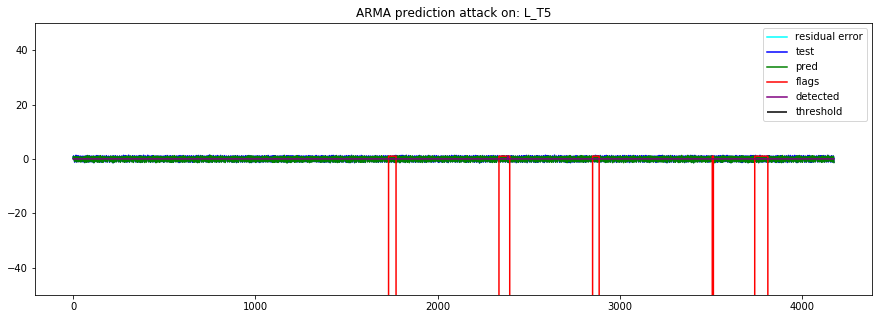

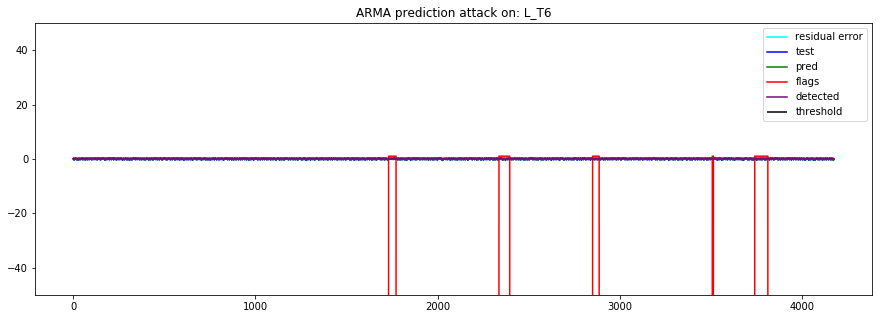

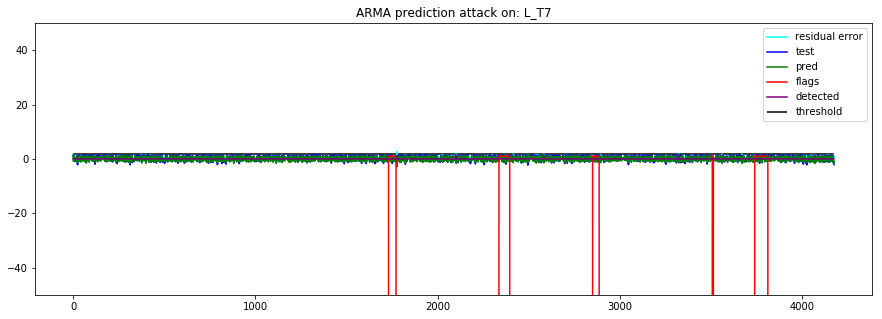

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


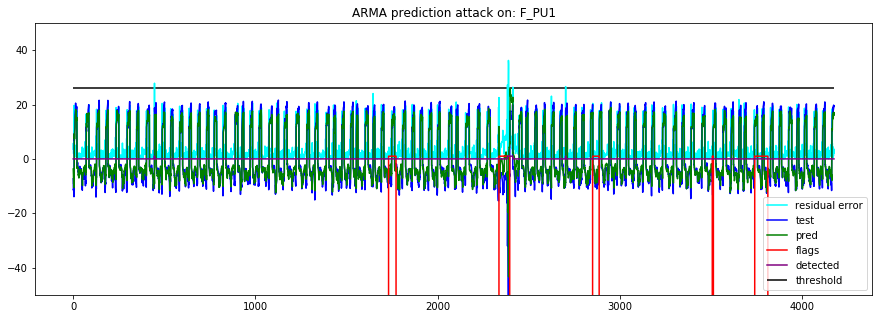

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


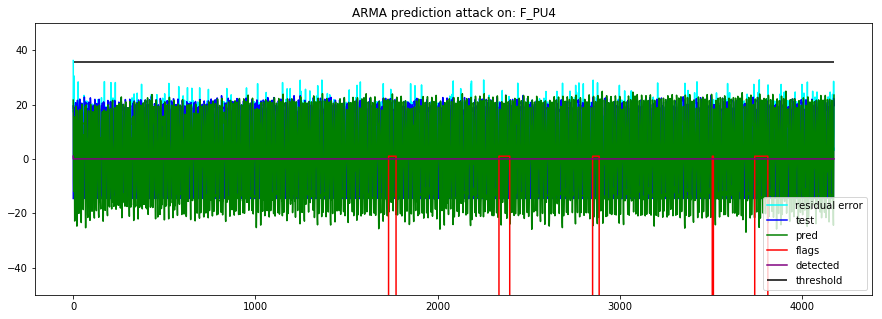

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


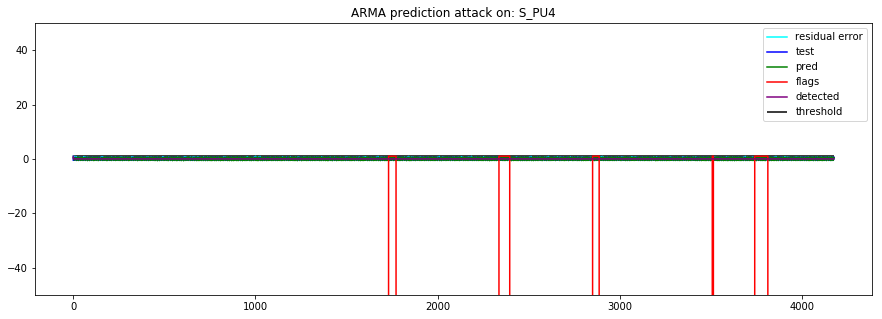

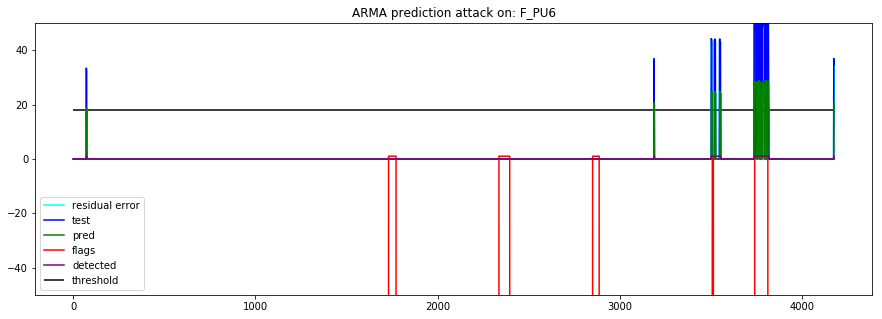

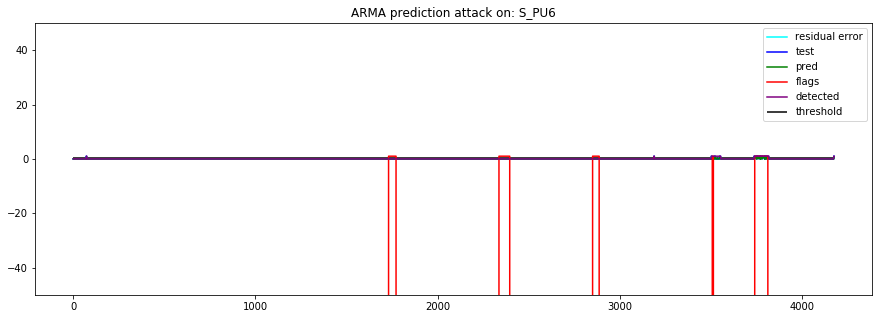

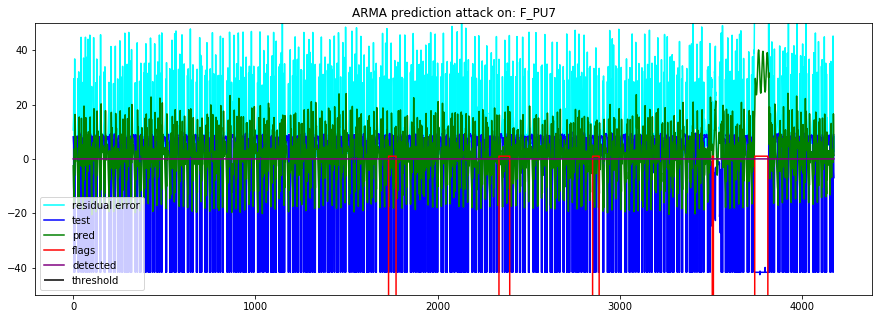

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


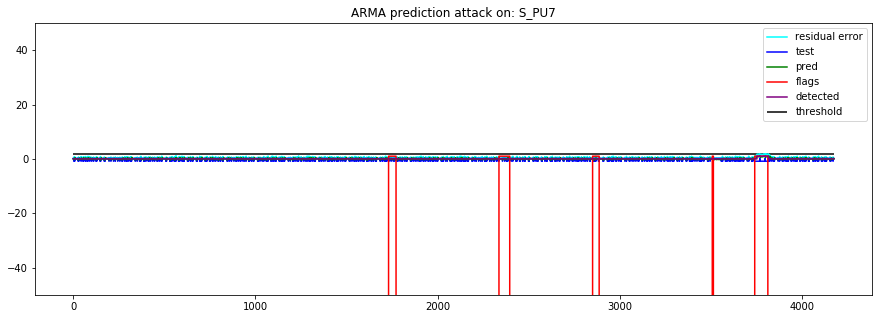

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


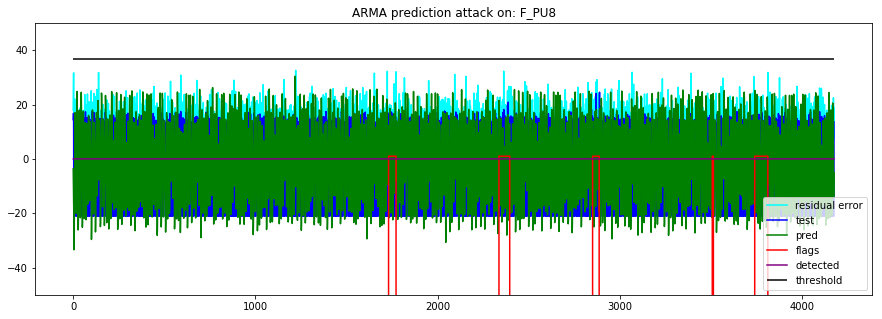

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


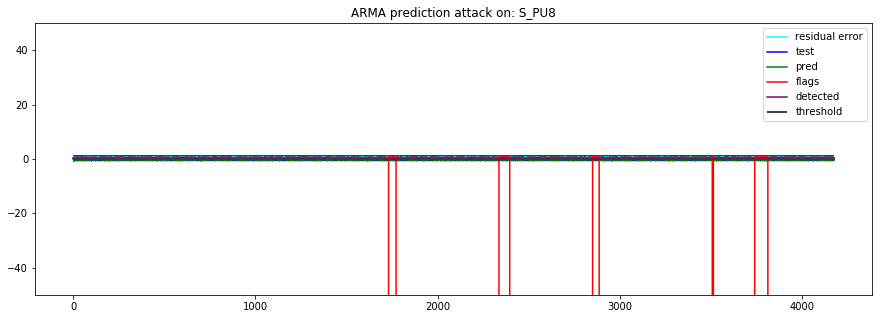

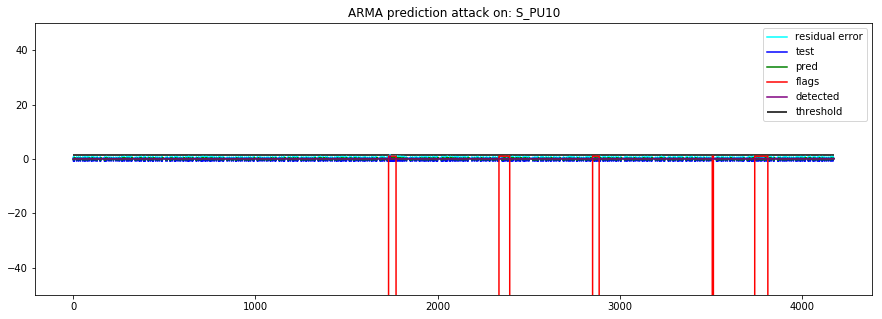

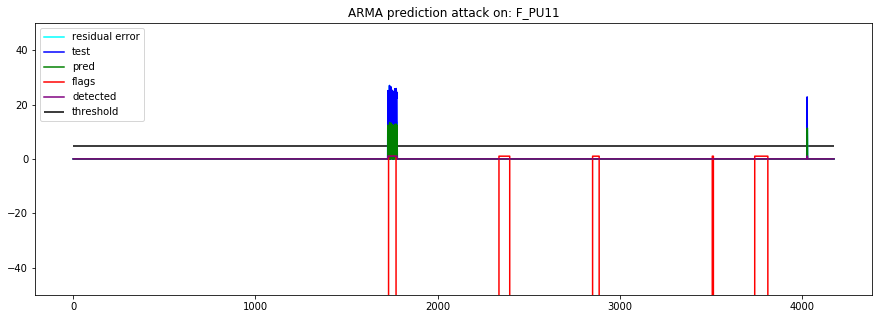

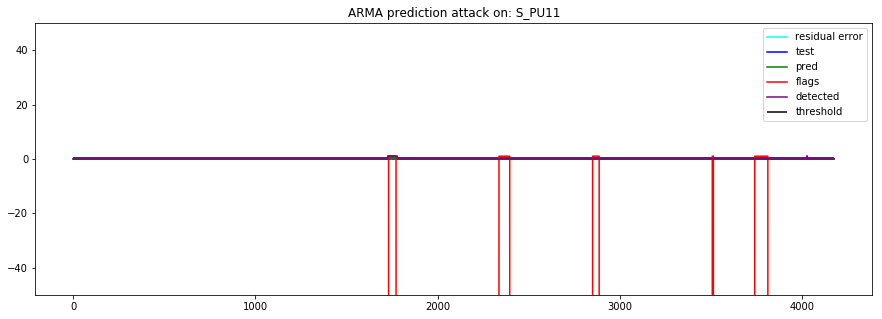

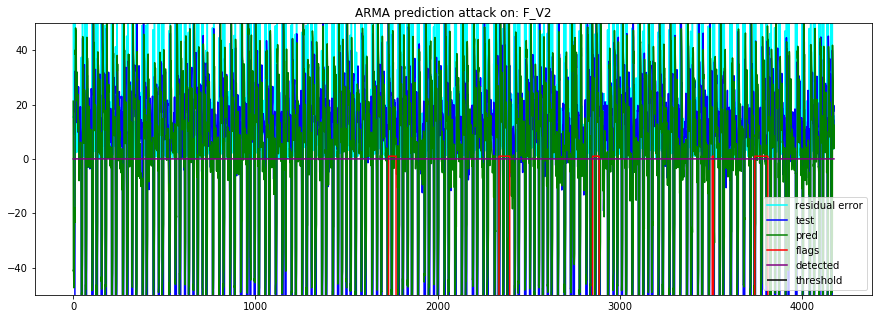

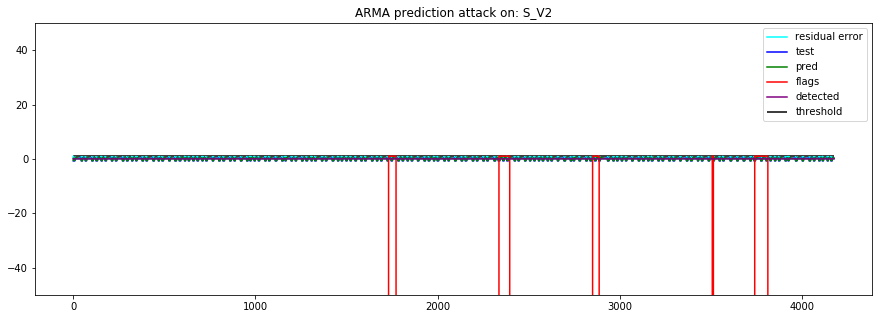

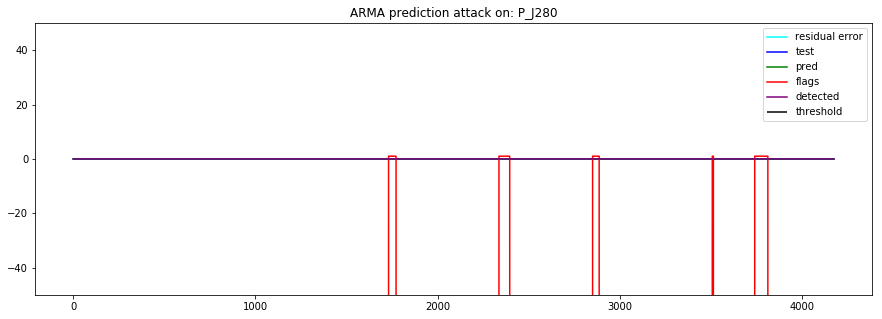

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


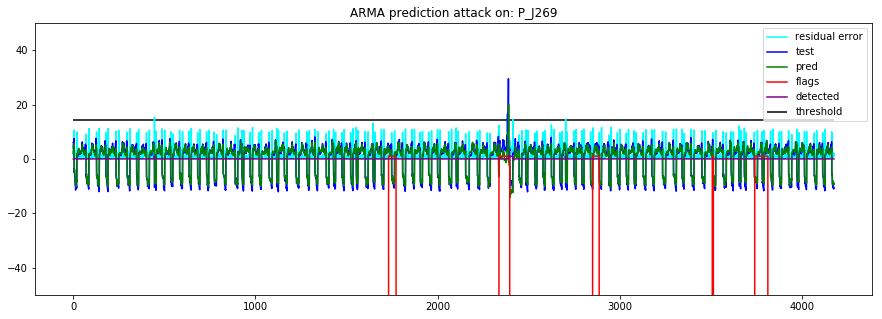

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


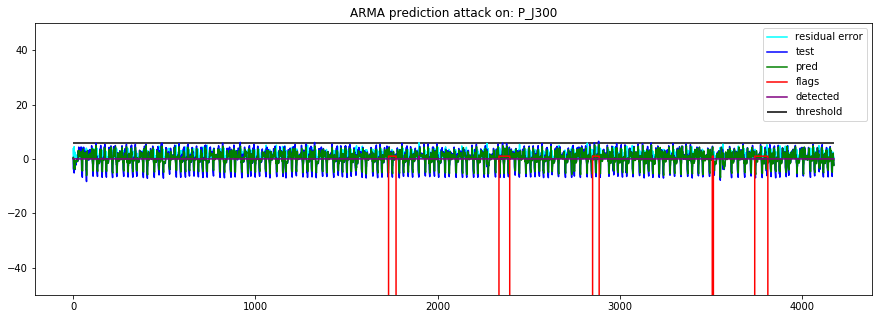

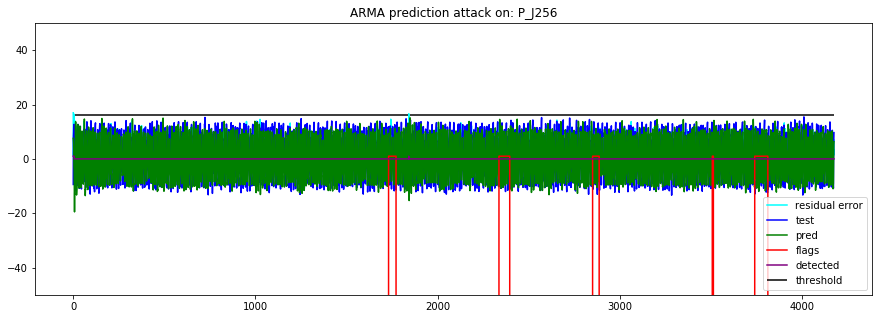

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


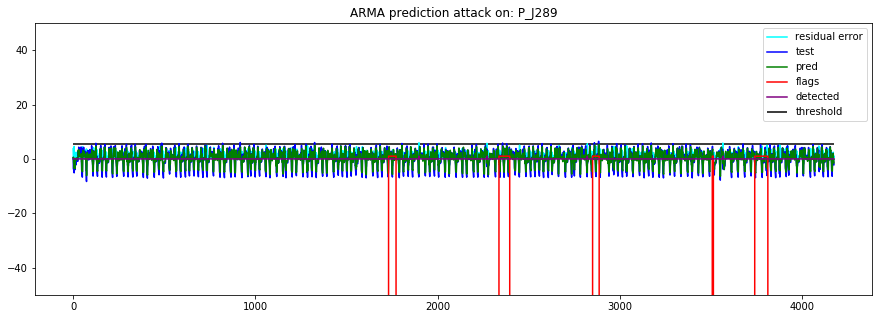

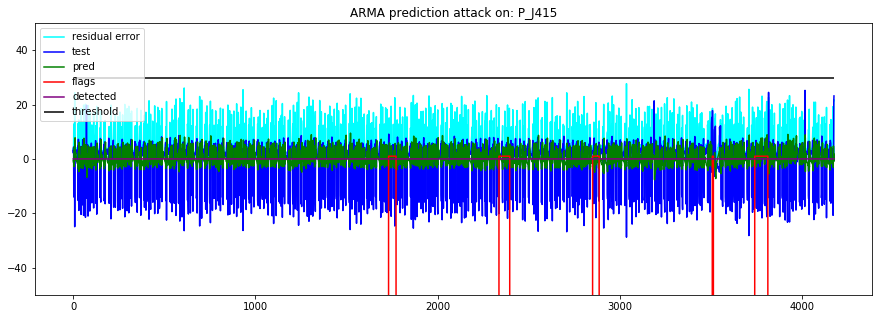

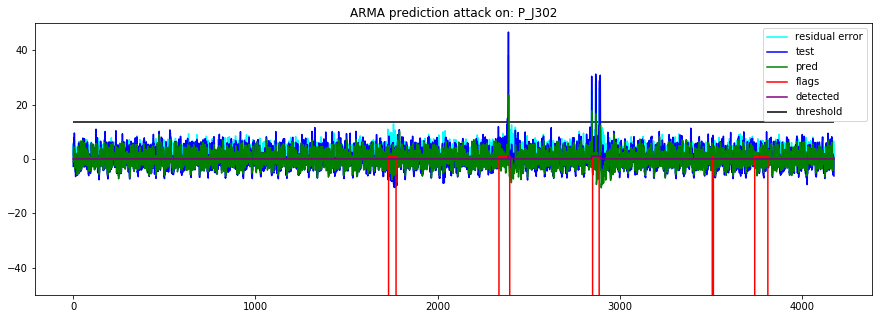

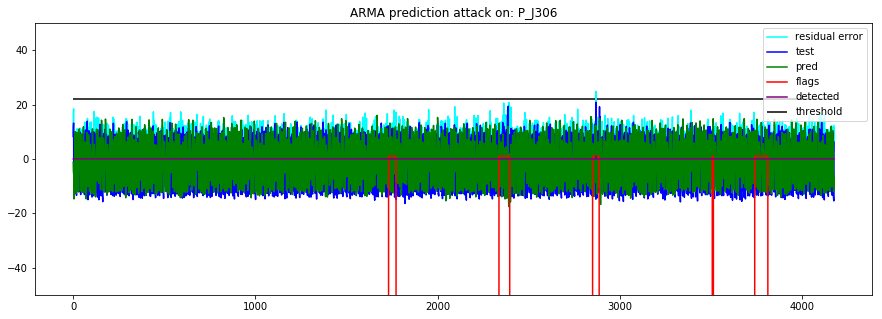

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


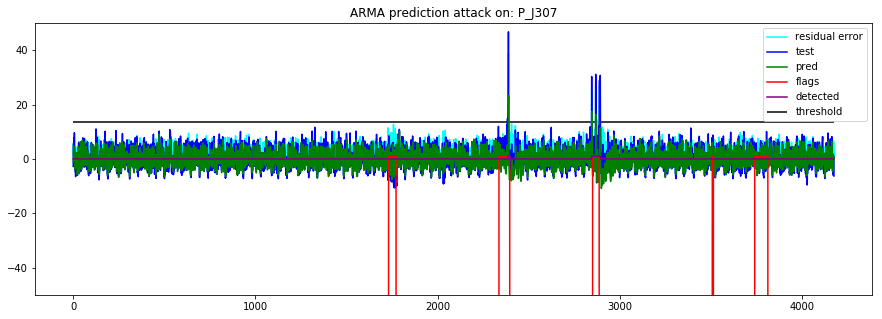

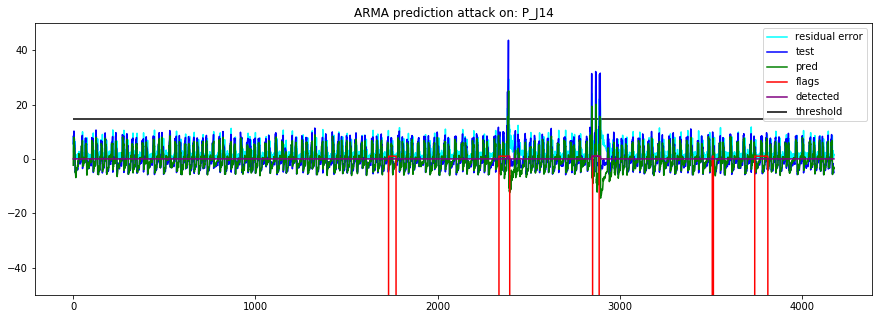

/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/roy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


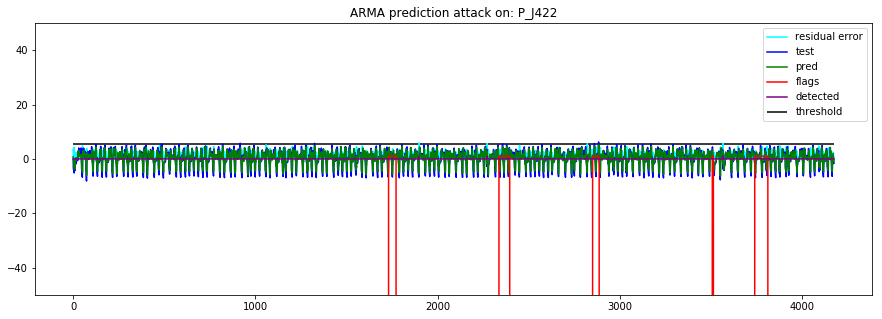

In [107]:
for signal in features:
    if arma_param[arma_param['feature'] == signal]['score'].values[0] != 'inf':
        p = arma_param[arma_param['feature'] == signal]['p'].values[0]
        q = arma_param[arma_param['feature'] == signal]['q'].values[0]
        try:
            arma_predict(data[signal], data2[signal], data2['ATT_FLAG'], signal, p=p, q=q)
        except:
            continue

# Discrete models task

Discretize the sensor data using any of the methods discussed in class. Explain why you choose this method and why the obtained discretization makes sense. Visualize the discretization. 

Apply any of the sequential data mining methods (N-grams, Sequence alignment with kNN, …) to sliding windows with a length of your choosing in order to find anomalies. Whenever an observed Ngram’s probability is too small, or the sequential data is too distant from any training sequence, raise an alarm. Set your thresholds sensibly. What kind of anomalies can you detect using the sequential model? Which sensors can be modeled effectively?

### Possible options for discretization:
- SAX (Symbolic Aggregate approXimation) 
SAX makes sense because it keeps the interesting information from the data: water level high/low/medium, and the flow of a certain pump is high/low/medium.
- Percentiles (.2 top, .02 bottom, .6 middle?)
Percentiles does not make sense, because most of the data will be in top or bottom, boundaries would not make sense.
- Change point detection
CPD could be interesting for detecting a change point, which does not correlate with a pump/valve being turned on. Maybe we are not interested in how the level changes, but on that it is low. On the other hand, it does say a lot if it goes steeply down and stays like that for some time. But a SAX would then be more logic, because that is the real information we are using. It is also the case that it can go up/down all the time, but in effect just be very low. Then the very low is probably more interesting than it going down. Could be nice for making a state machine (e.g. from slight up to quickly down, etc)

Choices for discretization: Discretize every individual data point, an sequence of points, whit ot without gaps?
Behaviour to model: exact values, trends, differences, fluctuations? Do what makes sense and leads to interpretable outcomes. When uncertain: try different possibilities

### Possible options for modeling:
- Bayesian Network Distribution
- State machine
- Markov chains
- N-grams (markov chain based on sliding windows), needs to be combined with smoothing methods


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


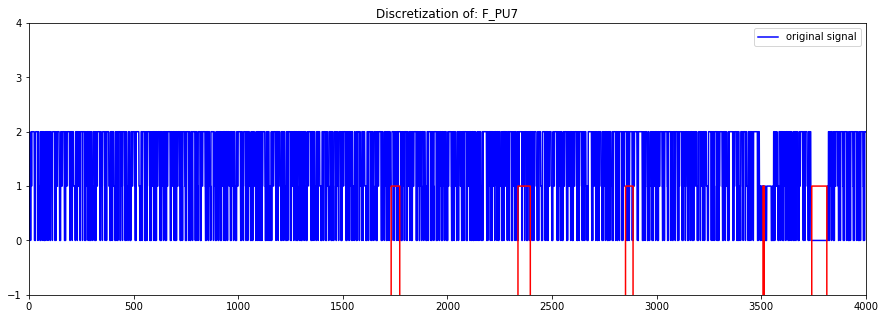

In [116]:
from tslearn.piecewise import SymbolicAggregateApproximation as SAX
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

feature_name = 'F_PU7'
dataset_to_use = data2
scaled_data = scaler.fit_transform(dataset_to_use)
feature_index = dataset_to_use.columns.get_loc(feature_name)
data_in_feature_column = scaled_data[:, feature_index]

nr_of_segments = 4000
alphabet_size = 3
fr = len(dataset_to_use)/nr_of_segments
decision_boundary_for_attack = -200

sax = SAX(n_segments=nr_of_segments, alphabet_size_avg=alphabet_size)
sax_data = sax.fit_transform(interesting_data)[0]

scaled_att = []
counter = 0
cs = 0
for i, value in enumerate(dataset_to_use['ATT_FLAG']):
#     print(i)        
    if value < decision_boundary_for_attack:
        value = 0
    elif value > decision_boundary_for_attack:
        value = alphabet_size 
        
    if i < counter + fr:
        cs += value
    else:
        scaled_att.append(cs/fr)
        counter += fr
        cs = 0
# plot
# print(scaled_att)
plt.figure(figsize=(15,5))
plt.plot(sax_data, color='blue')
plt.plot(dataset_to_use['ATT_FLAG'],'r')
# plt.plot(scaled_att,'r')

# plt.plot(residuals[start:end], color='green')
# plt.plot(attack_data[start:end], color='red')
axes=plt.gca()
axes.set_ylim((-1, alphabet_size + 1))
axes.set_xlim((0, nr_of_segments))
plt.legend(['original signal']) # , 'predicted signal', 'attack flag'])
plt.title('Discretization of: '+ feature_name)
plt.show()


[0. 0. 0. ... 0. 0. 0.]


Text(0.5, 1.0, 'SAX, 5 symbols')

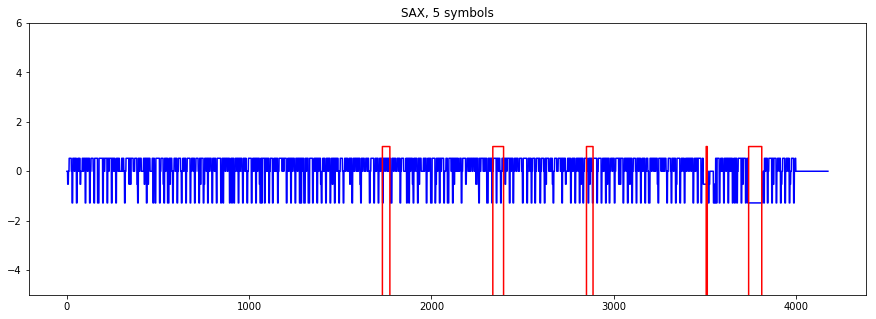

In [19]:
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


n_paa_segments = 1000
# TODO find out how large the alphabet should be
alphabet_size = 5
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=alphabet_size)

# scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)

# F_PU1 and F_PU7 both detect other anomalies
feature_name = 'F_PU7'
# feature_name = 'L_T1'
# feature_name = 'F_PU1'

dataset_to_use = data2.drop(columns={'DATETIME'})
# print(dataset_to_use)
feature_index = dataset_to_use.columns.get_loc(feature_name)
# print(feature_index)

scaled_data = scaler.fit_transform(dataset_to_use.values)
# print(scaled_data)
data_in_feature_column = scaled_data[:, feature_index]

sax_dataset_inv = sax.inverse_transform(sax.fit_transform(data_in_feature_column))

plt.figure(figsize=(15,5))
axes=plt.gca()
axes.set_ylim((-5, 5 + 1))
print(sax_dataset_inv[0].ravel())
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.plot(dataset_to_use['ATT_FLAG'],'r')
plt.title("SAX, %d symbols" % alphabet_size)

# PCA task

Perform PCA-based anomaly detection on the signal data. Set the threshold on training data to a value that results in few false positives on the training data. Plot the PCA residuals in one signal. Do you see large abnormalities in the training data? Can you explain why these occur? It is best to remove such abnormalities from the training data since you only want to model normal behavior. What kind of anomalies can you detect using PCA?

TODO:
* Normalizer (row-wise) vs Standerd Scaler(column-wise). (What happens to the poutliers on abnormalities when normalizing for a whole feature)
    * http://benalexkeen.com/feature-scaling-with-scikit-learn/
    * https://stackoverflow.com/questions/37221425/which-feature-scaling-method-to-use-before-pca
    * https://stackoverflow.com/questions/39120942/difference-between-standardscaler-and-normalizer-in-sklearn-preprocessing

### Normalize data

In [52]:
train_data = data.drop(columns=['ATT_FLAG', 'DATETIME'])
test_data1 = data2.drop(columns=['ATT_FLAG', 'DATETIME'])
test_data2 = data3.drop(columns=['DATETIME'])
pca_labels = train_data.columns


for col in train_data.columns:
    train_data[col] = train_data[col].astype('float')
    test_data1[col] = test_data1[col].astype('float')
    test_data2[col] = test_data2[col].astype('float')
    
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data1 = scaler.fit_transform(test_data1)
test_data2 = scaler.fit_transform(test_data2)

### Remove abnormalities from training data

2.5429633173584834
Removed columns: F_PU6 S_PU6 F_PU11 S_PU11 P_J415 P_J302 P_J307 P_J317 P_J14


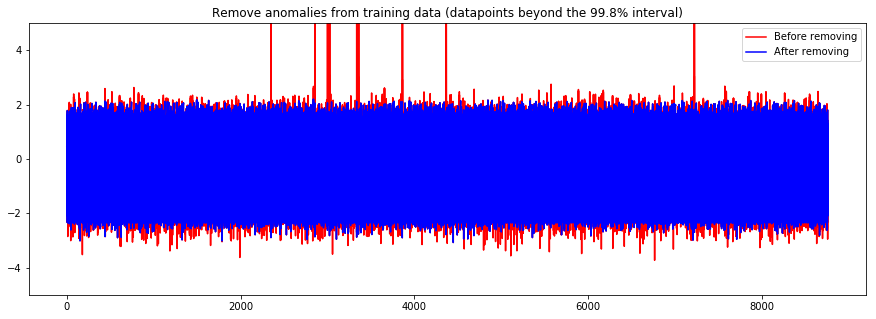

In [53]:
plt.figure(figsize=(15,5))
a = plt.plot(train_data, color='red', label='Before removing')

# calculate a 99.7% interval for every feature to remove anomalies from the normal data
mean_per_col = np.mean(train_data, axis=1)
std_per_col = np.std(train_data, axis=1)
interval = mean_per_col + 3*std_per_col

#threshold is the mean of the feature intervals
threshold = np.mean(interval)
print(threshold)

# append collumn numbers that contains anomalies to list
abnormalities_in_trainig_data = []
for row in train_data:
    for i, cell in enumerate(row):
        if cell > threshold:
            abnormalities_in_trainig_data.append(i)
abnormalities_in_trainig_data = np.unique(abnormalities_in_trainig_data)

print('Removed columns:', *itemgetter(abnormalities_in_trainig_data)(pca_labels))
pca_labels_filtered = np.delete(pca_labels, list(abnormalities_in_trainig_data), axis=0)

# Remove collumns from training data that contains anomalies
train_data = np.delete(train_data, list(abnormalities_in_trainig_data), axis=1)
test_data1 = np.delete(test_data1, list(abnormalities_in_trainig_data), axis=1)
test_data2 = np.delete(test_data2, list(abnormalities_in_trainig_data), axis=1)

b = plt.plot(train_data, color='blue', label='After removing')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().set_ylim((-5,5))
plt.title('Remove anomalies from training data (datapoints beyond the 99.8% interval)')
plt.show()


### Calculate number of principle comonents to reach a certain threshold

In [56]:
pca = PCA()
pca.fit(train_data)
expl_var = pca.explained_variance_ratio_

for i in range(1, len(expl_var)+1):
    var_sum = np.sum(expl_var[0:i])
    n_significant = i
    print('first',i,'components explains: ', round(var_sum*100,2),'%')
    if var_sum > 0.99:
        break
    

first 1 components explains:  25.9 %
first 2 components explains:  42.77 %
first 3 components explains:  54.38 %
first 4 components explains:  64.69 %
first 5 components explains:  72.06 %
first 6 components explains:  78.28 %
first 7 components explains:  83.77 %
first 8 components explains:  87.96 %
first 9 components explains:  91.28 %
first 10 components explains:  94.55 %
first 11 components explains:  96.93 %
first 12 components explains:  98.75 %
first 13 components explains:  99.68 %


### Reconstruct the test data, plot the residuals and detect anomalies

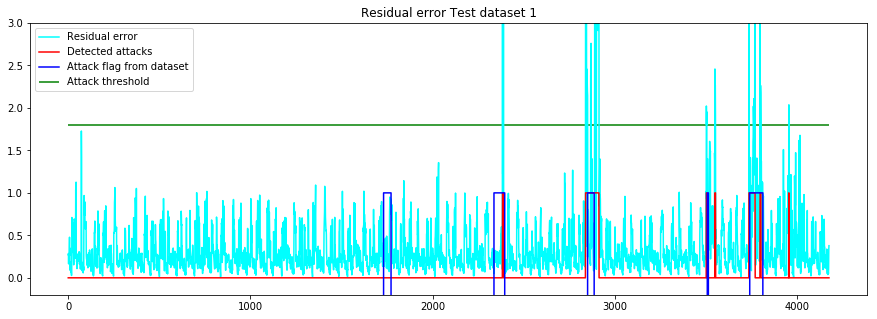

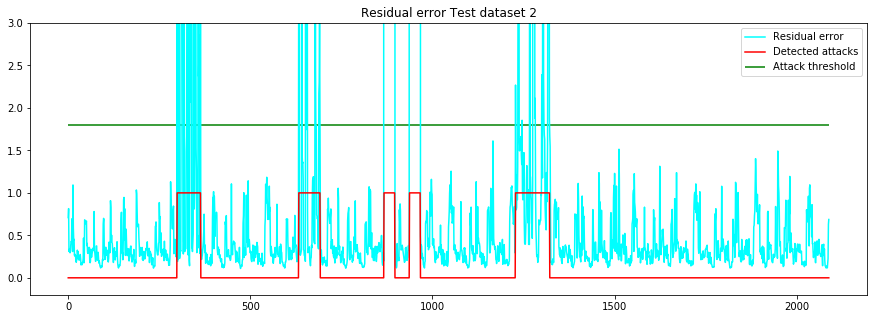

In [80]:
# Initialize PCA() with n components and fit the model with the training data
pca = PCA(n_components=n_significant)
pca.fit(train_data)

# transform function returns matrix inf form of [n_samples X n_components]
train_projection = pca.transform(train_data)
test_projection1 = pca.transform(test_data1)
test_projection2 = pca.transform(test_data2)

# returns components matrix in form of [n_components X n_features]
components = pca.components_

# original data has form [n_samples X n_features]
# recreate data with matrix multiplication of projection and components
train_recreate = np.matmul(train_projection,components)
test_recreate1 = np.matmul(test_projection1,components)
test_recreate2 = np.matmul(test_projection2,components)

#calculate squared error for every sample (row)
train_residual_error = np.sum( np.square( np.subtract(train_data, train_recreate) ),axis=1)
test_residual_error1 = np.sum( np.square( np.subtract(test_data1, test_recreate1) ),axis=1)
test_residual_error2 = np.sum( np.square( np.subtract(test_data2, test_recreate2) ),axis=1)



# threshold_calc = list(np.sort(test_residual_error))
# threshold_calc = threshold_calc[0:int(len(threshold_calc)*0.95)]
# pca_threshold = np.amax(threshold_calc)

# include 95.4% of the data by setting the threshold on mean+2*std
# pca_threshold = np.mean(test_residual_error)+2*np.std(test_residual_error)
# print(pca_threshold)

pca_threshold = 1.8

# Decide wheter it is an attack or not
attacks_test1 = []
for row in test_residual_error1:
    attacks_test1.append(1 if row>pca_threshold else 0)

attacks_test2 = []
for row in test_residual_error2:
    attacks_test2.append(1 if row>pca_threshold else 0)
    
# group attacks
group_threshold = 25
for i, row in enumerate(attacks_test1):
    if row == 1:
        if i+group_threshold>len(attacks_test1):
            group_threshold = len(attacks_test1) - i - 1
        for check in range(i+group_threshold,i, -1):
            
            if attacks_test1[check] == 1:
                for fill in range(check, i, -1):
                    attacks_test1[fill] = 1 
                    
group_threshold = 25
for i, row in enumerate(attacks_test2):
    if row == 1:
        if i+group_threshold>len(attacks_test2):
            group_threshold = len(attacks_test2) - i - 1
        for check in range(i+group_threshold,i, -1):
            
            if attacks_test2[check] == 1:
                for fill in range(check, i, -1):
                    attacks_test2[fill] = 1 
            
    


plt.figure(figsize=(15,5))
plt.hlines(pca_threshold, 0, len(test_residual_error1), label='Attack threshold', color='green')
plt.plot(test_residual_error1, label='Residual error', color='cyan')
plt.plot(attacks_test1, label='Detected attacks', color='red',)
plt.plot(data2['ATT_FLAG'], label='Attack flag from dataset', color='blue')
plt.title('Residual error Test dataset 1')
plt.gca().set_ylim((-0.2, 3))
plt.legend()
plt.show()
    
plt.figure(figsize=(15,5))
plt.hlines(pca_threshold, 0, len(test_residual_error2), label='Attack threshold', color='green')
plt.plot(test_residual_error2, label='Residual error', color='cyan')
plt.plot(attacks_test2,  label='Detected attacks', color='red',)
plt.title('Residual error Test dataset 2')
plt.gca().set_ylim((-0.2, 3))
plt.legend()
plt.show()
    

# Comparison task

Compare the performance of the PCA method with the ARMA and discrete models. Comparing anomaly detection methods in not straightforward, and different research studies frequently use different measures. You can either:
* test point-wise precision and recall, or
* overlap-based false and true positives, or /and
* count a true positive if it detects at least one anomaly in an anomalous region, or
* compare the top-k detected anomalies,
* or...

Describe in a few lines which comparison method you chose for this data and why. Keep in mind that
in practice an analyst has to take action on every positive detected, but will not study every detected
data point. Do you recommend using PCA, ARMA, or discrete models?

# Bonus task

Use PyTorch (or another framework) to learn Deep Neural Networks for anomaly detection as discussed in class and in the literature. Try out different learning rates and detection thresholds. Compare the performance with the three approaches tested above. Do you recommend using Deep Learning? Why (not)?